In [1]:
from Data.data_dicts import character_dict, source_dict, random_state

characters = ['Barney' , 'Sheldon' , 'Harry' , 'Fry' , 'Vader' , 'Joey' , 'Phoebe' , 'Bender']

In [2]:
# Mount google drive
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    # Install dependencies
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = os.getcwd()

# Set metrics folder for inputs
in_metrics_folder = os.path.join(base_folder, 'Metrics')
if not os.path.exists(in_metrics_folder):
    os.makedirs(in_metrics_folder)

# Set metrics folder for outputs
out_metricsPlot_folder = os.path.join(base_folder, 'Metrics', 'Plots')
if not os.path.exists(out_metricsPlot_folder):
    os.makedirs(out_metricsPlot_folder)

In [3]:
# Import for general utilities
import pandas as pd
import tensorflow as tf
import json
import numpy as np
import time
import scipy as sp
from datasets import load_dataset, DatasetDict
from tqdm import tqdm 
from matplotlib import pyplot as plt
%matplotlib inline
from itertools import product as zip_cartesian
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import BBRadar for plot a radar plot for Emotion metric 
from Lib.BBRadar import BBRadar

# Metrics Visualizations

In this notebook we are going to show the results obtained by the evaluation of all the metrics. All the results will then be stored in an apposite path folder named `Metrics\Path`

## Plot functions definition

Below it will be found the definition of the functions used to plot the result metrics

The following function is used to load a specific character dataset in function of his name.

In [5]:
def load_df(character):
    # Builds the path where the dataset is stored
    dataset_path = os.path.join(base_folder, "Data", "Characters", character, character+'.csv')
    
    # Loads the datasat of the character `character`
    character_hg = load_dataset('csv', 
                                data_files=dataset_path, 
                                cache_dir=os.path.join(base_folder, "cache"))
    
    # 85% train / 10% test / 5% validation
    train_test_hg = character_hg['train'].train_test_split(test_size=0.15, seed=random_state)
    test_val = train_test_hg['test'].train_test_split(test_size=0.33, seed=random_state)
    
    # This gives a name to three splits of the dataset
    character_hg = DatasetDict({
        'train': train_test_hg['train'],
        'test': test_val['train'],
        'val': test_val['test']
    })
    
    return character_hg

This function is used to plot all the datasets splitted in _train_, _validation_ and _test_ in one single graph.

In [6]:
def plot_datasets(charList, characters_hg, colors=['red','orange','gold']):
    # Number of characters
    n = len(charList)
    # Number of sets for each character
    m = len(characters_hg[0])
    # List of datasets identyfier, contained in the dataset `characters_hg`
    sets = [s for s in characters_hg[0]]
    
    # The xlabels are the name of characters
    xlabels = charList
    # Extract lenght of each dataset and of each character, and store it in a vector
    data   = np.array([[len(characters_hg[c][s]) for c in range(n)] for s in sets])
    
    # Plots the dataset
    fig, ax = plt.subplots(facecolor='white', figsize=(15, 10))
    for s in range(m):
        ax.bar(xlabels, data[s], 0.3, color=colors[s])
    ax.set_xlabel('Set')
    ax.set_ylabel('Number of lines')
    ax.set_title('Barplot of Dataset of all characters', fontweight="bold")
    ax.legend([hgdict for hgdict in characters_hg[0]])
    ax.grid(True)
    
    # Save the figure
    fig.savefig(os.path.join(out_metricsPlot_folder, 'Datasets characters'), dpi=fig.dpi)
    return None

The function below constructs a unique plot for showing all the metrics results for the associated case

In [7]:
def plot_metrics(metrics, title, c1, c2=None, 
                 cols=4, colors=['tab:blue', 'tab:orange', 'tab:orange', 'tab:red']):
    # Reads the metadata
    metadata = metrics['metadata']
    # Let's take the number of metrics to show
    metrics_size = len(metrics) + 1
    # If the number of metrics to show
    if not metrics_size % cols == 0:
        # There is a need to add an extra row in the plot
        rows = metrics_size // cols + 1
    else: 
        # Otherwise we don't need any extra rows
        rows = metrics_size // cols
    
    # Prepare the plot with subplots
    fig = plt.figure(figsize=(20, 10), facecolor='white')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)
    # This is the index of the subplots
    idx = 1
    
    # Metrics:
    ### Semantic Similarity
    m = 'semantic similarity'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            # Extract the score with the standard deviation
            data.append(s['score'])
            std.append(s['std'])
        except:
            # Extract the ccl score
            data.append(s)
            std.append(0)
    labels = metadata[m]['ordering']
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(labels, np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    ### Bleu
    m = 'bleu'
    data = []
    std  = [0 for _ in range(len(metrics[m]))]
    for s in metrics[m]:
        try:
            # Extract the score
            data.append(s['score'])
        except:
            # Extract the ccl score
            data.append(s)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    ### Rouge l
    m = 'rouge l'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            # Extract the score with the standard deviation
            data.append(s['score'])
            std.append(s['std'])
        except:
            # Extract the ccl score
            data.append(s)
            std.append(0)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    ### Distinct
    m = 'distinct'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            # Extract the score with the standard deviation
            data.append(s['score'])
            std.append(s['std'])
        except:
            # Extract the ccl score
            data.append(s)
            std.append(0)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'],rotation=25)
    ax.grid(True)
    idx += 1

    ### Perplexity
    m = 'perplexity'
    try:
        ax = fig.add_subplot(rows, cols, idx)
        ax.axis('off')
        if isinstance(metrics[m], list):
            ax.text(0.5, 0.25, metadata[m]['ordering'][1] + ' ' + str(np.round(metrics[m][1], decimals=2)), 
                    fontweight='bold', size=18, ha='center', va='center', color=colors[0])
            ax.text(0.5, 0.75, metadata[m]['ordering'][0] + ' ' + str(np.round(metrics[m][0], decimals=2)), 
                    fontweight='bold', size=18, ha='center', va='center', color=colors[1])
        else:
            ax.text(0.5, 0.5, str(np.round(metrics[m], decimals=2)), fontweight='bold', 
                    size=35, ha='center', va='center', color=colors[1])
        ax.set_title(m, fontweight="bold")
        idx += 1
    except:
        pass
    
    ### Emotion
    m = 'emotion'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            # Extract the score with the standard deviation
            data.append(s['score'])
            std.append(s['std'])
        except:
            # Extract the pearson correlation
            data.append(s)
            std.append(0) 
    labels = metrics[m][0]['label']
    ordering = metadata[m]['ordering']
    # 0 - context, 1 - label, 2 - chatbot 
    radar = BBRadar(labels, data[0], data[1], ordering[0]) # context
    radar.subplotEmotionsRadar(rows, cols, fig, idx, legend=ordering[0].split('-'), 
                               colors=['tab:orange', 'tab:blue'])
    idx +=1
    radar = BBRadar(labels, data[0], data[2], ordering[1]) # label 
    radar.subplotEmotionsRadar(rows, cols, fig, idx, legend=ordering[1].split('-'), 
                               colors=['tab:orange', 'tab:blue'])
    idx +=1
    radar = BBRadar(labels, data[2], data[1], ordering[2]) # chatbot
    radar.subplotEmotionsRadar(rows, cols, fig, idx, legend=ordering[2].split('-'), 
                               colors=['tab:orange', 'tab:blue'])
    idx +=1
    # Emotion pearson correlation
    ax = fig.add_subplot(rows, cols, idx)
    ax.barh(np.array([0.5]), 1, 0.5, color='white', edgecolor='black', linewidth=2)
    ax.set_title(m + ' pearson correlation',fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xlim([-0.1,1.1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([-1, 0, 1])
    ax.set_yticklabels([], rotation=25)
    ax.axvline(x=data[3], ymin=0.2, ymax=0.8, color=colors[1], lw=2)
    ax.grid(True)
    idx += 1
    
    ### Semantic answer similarity
    m = 'semantic answer similarity'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            # Extract the score with the standard deviation
            data.append(s['score'])
            std.append(s['std'])
        except:
            # Extract the pearson correlation
            data.append(s)
            std.append(0)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    ### Semantic classifier
    m = 'semantic classifier'
    data = []
    std  = []
    for s in metrics[m]:
        data.append(s['score'])
        std.append(s['std'])
    ax = fig.add_subplot(rows, cols, idx)
    labels = metadata[m]['ordering']
    ax.bar(labels, np.array(data), 0.3, yerr=std, color=['tab:orange', 'tab:blue'])
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(labels, rotation=25)
    ax.grid(True)
    idx += 1
    
    # Set title
    fig.text(0.2, 0.965, title, horizontalalignment='center', color='black', weight='bold',
             size=22)
    fig.savefig(os.path.join(out_metricsPlot_folder, title), dpi=fig.dpi)
    return None

The following function read metrics from the specified `metric_path`

In [8]:
def read_metric(metric_path):
    # If `metric_path` exits
    if os.path.exists(metric_path):
        # Open and read the file
        with open(metric_path, 'r') as file:
            json_string = file.read()
        metrics = json.loads(json_string)
        return metrics
    else:
        raise Exception("Loading " + metric_path + " failed!")

# Plots and save results

Finally plots the metrics

In [9]:
def plotMetricsChars(charList):
    # Loads from the cache datasets
    os.environ["HF_DATASETS_CACHE"] = os.path.join(base_folder, "cache")
    # Loads all datasets for all the character 
    characters_hg = [load_df(c) for c in charList]
    
    # Plots datasets
    plot_datasets(charList, characters_hg)
    
    # Try to plot each couple c1, c2  
    for c1_id in range(len(charList)):
        # Get the name
        c1 = charList[c1_id]
        print('### character', c1)
        
        # Plots the metrics of base
        base_metrics_path          = os.path.join(base_folder, "Metrics", 
                                                  c1+'_base_metrics.json')
        base_metric = read_metric(base_metrics_path)
        plot_metrics(base_metric, "Metrics " + c1 + ' base', c1)
        

        # Plots the metrics of the 3 search strategies
        base_metrics_sampling_path = os.path.join(base_folder, "Metrics", 
                                                  c1+'_sampling_comparison_metrics.json')
        base_metrics_sampling = read_metric(base_metrics_sampling_path)
        for search_strategy in ['greedy_vs_nbeams', 'greedy_vs_sampling', 'nbeams_vs_sampling']:
            plot_metrics(base_metrics_sampling[search_strategy], 
                         "Metrics " + c1 + ' search ' + search_strategy.replace('_', ' '),  c1)
        
        # Plots the metrics c1 vs Not Fine Tuned
        c1_vs_nf_metrics_path = os.path.join(base_folder, "Metrics", 
                                             c1+'_vs_nonfinetuned_metrics.json')
        c1_vs_nf_metrics = read_metric(c1_vs_nf_metrics_path)
        plot_metrics(c1_vs_nf_metrics, "Metrics " + c1 + ' vs Not Finetuned', c1)
        
        # Plots the confront with c2
        for c2_id in tqdm(range(len(charList))):
            if c1_id != c2_id:
                c2 = charList[c2_id]
                c1_vs_c2_metrics_path = os.path.join(base_folder, "Metrics", 
                                                     c1+'_vs_'+c2+'_metrics.json')
                try:
                    # If the c1 vs c2 metrics file exists
                    c1_vs_c2_metrics = read_metric(c1_vs_c2_metrics_path)
                    # and plots the c1 vs c2 metrics
                    plot_metrics(c1_vs_c2_metrics, 'Metrics ' + c1 + ' vs ' + c2, c1, c2)
                except:
                    pass

Finally let's plot all the metrics

Using custom data configuration default-97685b2cbe1ddbbf
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-97685b2cbe1ddbbf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-97685b2cbe1ddbbf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-c9542bdc5444f3d7.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-97685b2cbe1ddbbf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-4dbcf4526942d3fd.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-97685b2cbe1ddbbf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-72544fd22e19903d.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-97685b2cbe1ddbbf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-460632b815e1339c.arrow
Using custom data configuration default-12ed4688fb85bf92
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-12ed4688fb85bf92\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-12ed4688fb85bf92\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-b9c08c9b5bd0b11c.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-12ed4688fb85bf92\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-109822d27a8a5893.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-12ed4688fb85bf92\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-d47aa61a48b951fa.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-12ed4688fb85bf92\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-631d450c3b14d191.arrow
Using custom data configuration default-e89bfbbde86bec31
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-e89bfbbde86bec31\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-e89bfbbde86bec31\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-94692942158511bd.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-e89bfbbde86bec31\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-6e4e9753c343a87d.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-e89bfbbde86bec31\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-b14df2124e567682.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-e89bfbbde86bec31\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-1d3a1a6cce48b735.arrow
Using custom data configuration default-128e4162ca50ff09
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-128e4162ca50ff09\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-128e4162ca50ff09\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-694d43f92229d32c.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-128e4162ca50ff09\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-fac79f36c371372a.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-128e4162ca50ff09\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-424d510cfd453d9a.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-128e4162ca50ff09\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-28e022666549ce2f.arrow
Using custom data configuration default-bb7163957ad08048
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-bb7163957ad08048\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-bb7163957ad08048\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-a65ebcf8e6a6644c.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-bb7163957ad08048\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-905b069ad6248b52.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-bb7163957ad08048\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-810dc2fcfee2f21b.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-bb7163957ad08048\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-b41a6ae0339770cd.arrow
Using custom data configuration default-561718eeb8e527e4
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-561718eeb8e527e4\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-561718eeb8e527e4\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-d79c9e8f6934cc9f.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-561718eeb8e527e4\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-12ce69de4a40ac54.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-561718eeb8e527e4\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-3c5d89d9e8fcfc48.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-561718eeb8e527e4\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-3a73e19a857075bb.arrow
Using custom data configuration default-90aa3fce8a66bb12
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-90aa3fce8a66bb12\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-90aa3fce8a66bb12\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-eb9aca486245fc8e.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-90aa3fce8a66bb12\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-d97d1f69dafed9bb.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-90aa3fce8a66bb12\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-56d3b88b6c491727.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-90aa3fce8a66bb12\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-bc00487c73285c4e.arrow
Using custom data configuration default-fb4e82817b294541
Reusing dataset csv (C:\Users\User\Documents\GitHub\cache\csv\default-fb4e82817b294541\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-fb4e82817b294541\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-1a9218d69124850f.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-fb4e82817b294541\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-017783ea912729c6.arrow
Loading cached split indices for dataset at C:\Users\User\Documents\GitHub\cache\csv\default-fb4e82817b294541\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-dc31a28cd9499460.arrow and C:\Users\User\Documents\GitHub\cache\csv\default-fb4e82817b294541\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-cbc2e1a008e7283d.arrow


### character Barney


100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


### character Sheldon


100%|██████████| 8/8 [00:02<00:00,  3.83it/s]


### character Harry


100%|██████████| 8/8 [00:00<?, ?it/s]


### character Fry


100%|██████████| 8/8 [00:00<00:00,  8.53it/s]


### character Vader


100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


### character Joey


100%|██████████| 8/8 [00:00<00:00, 8008.22it/s]


### character Phoebe


100%|██████████| 8/8 [00:00<00:00, 10.94it/s]


### character Bender


100%|██████████| 8/8 [00:00<?, ?it/s]


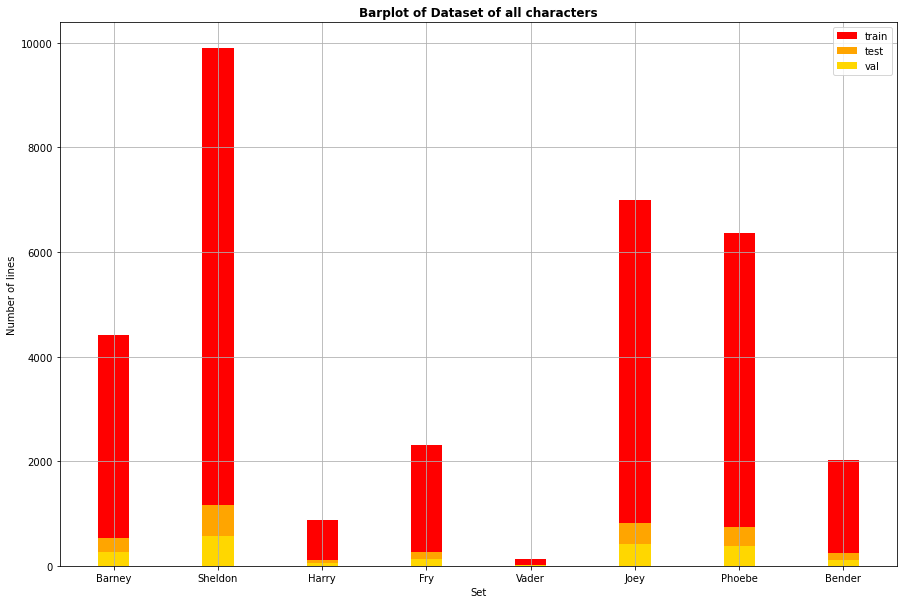

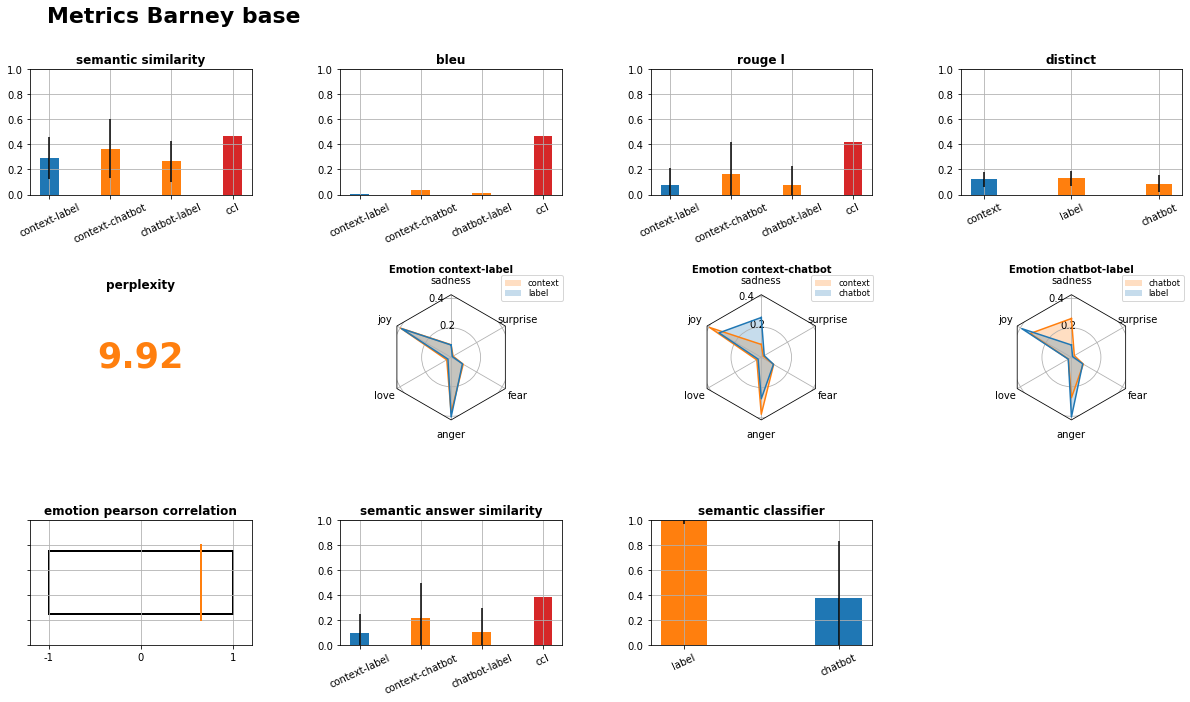

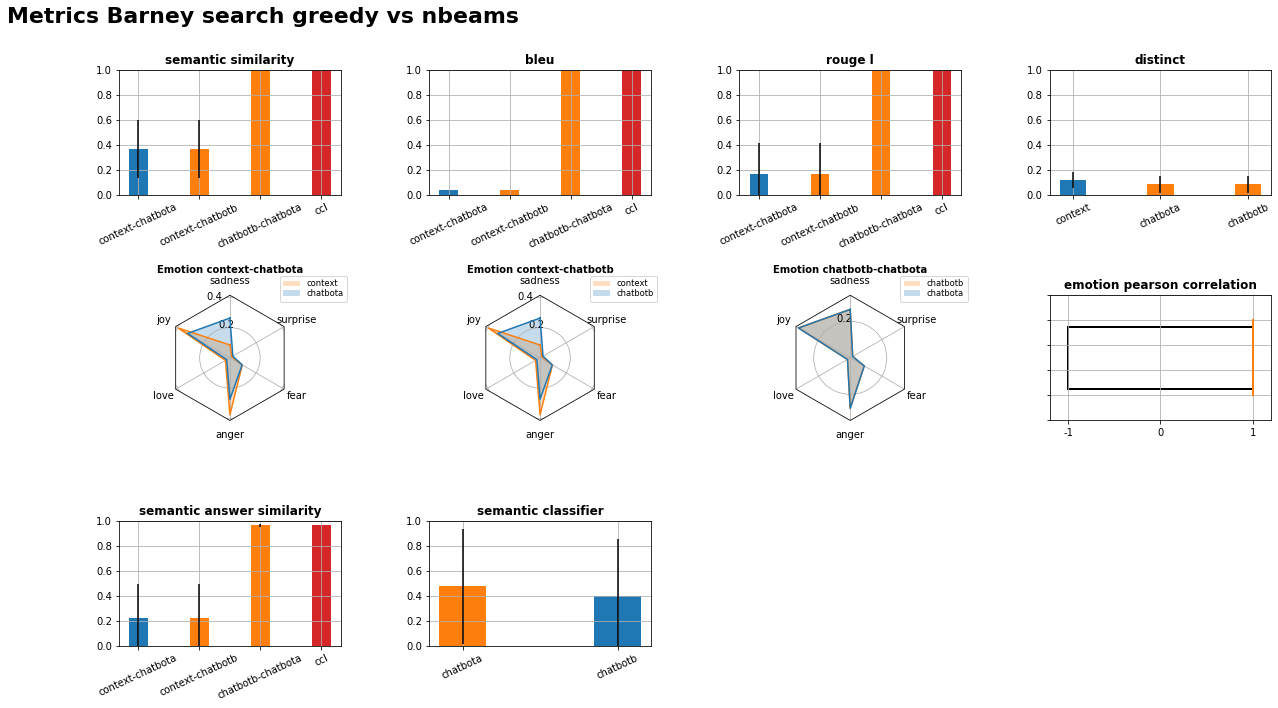

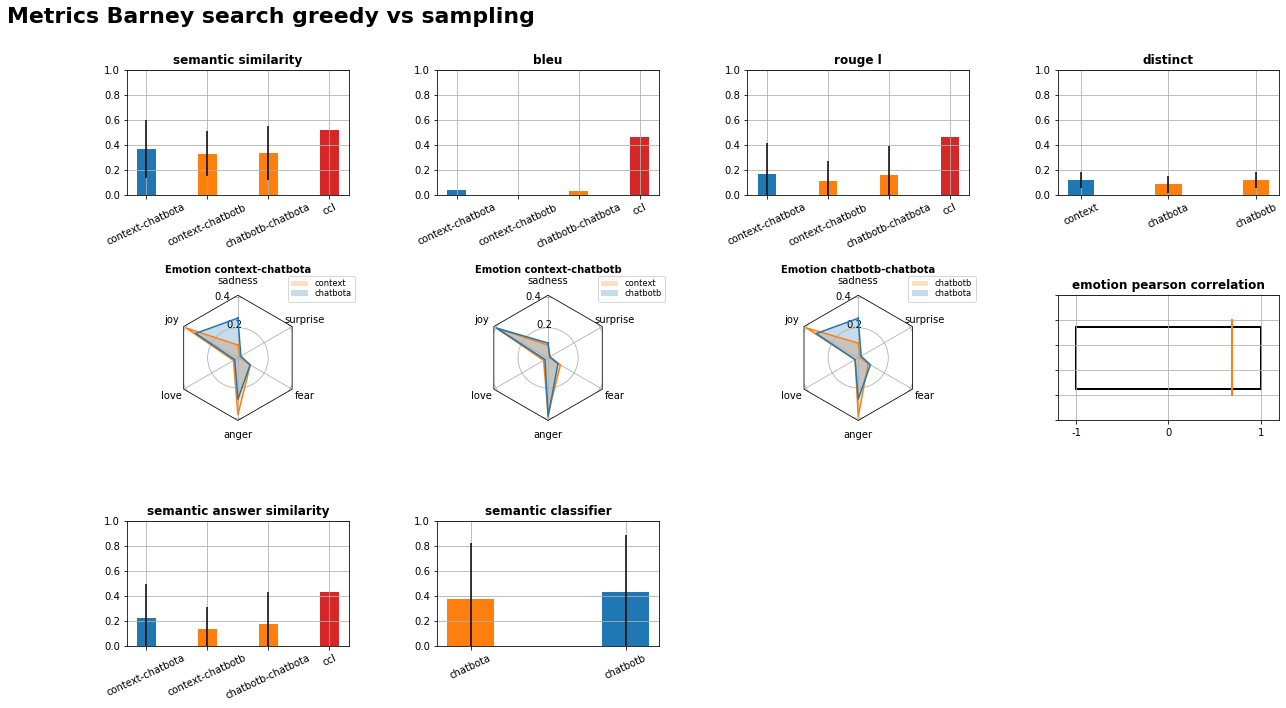

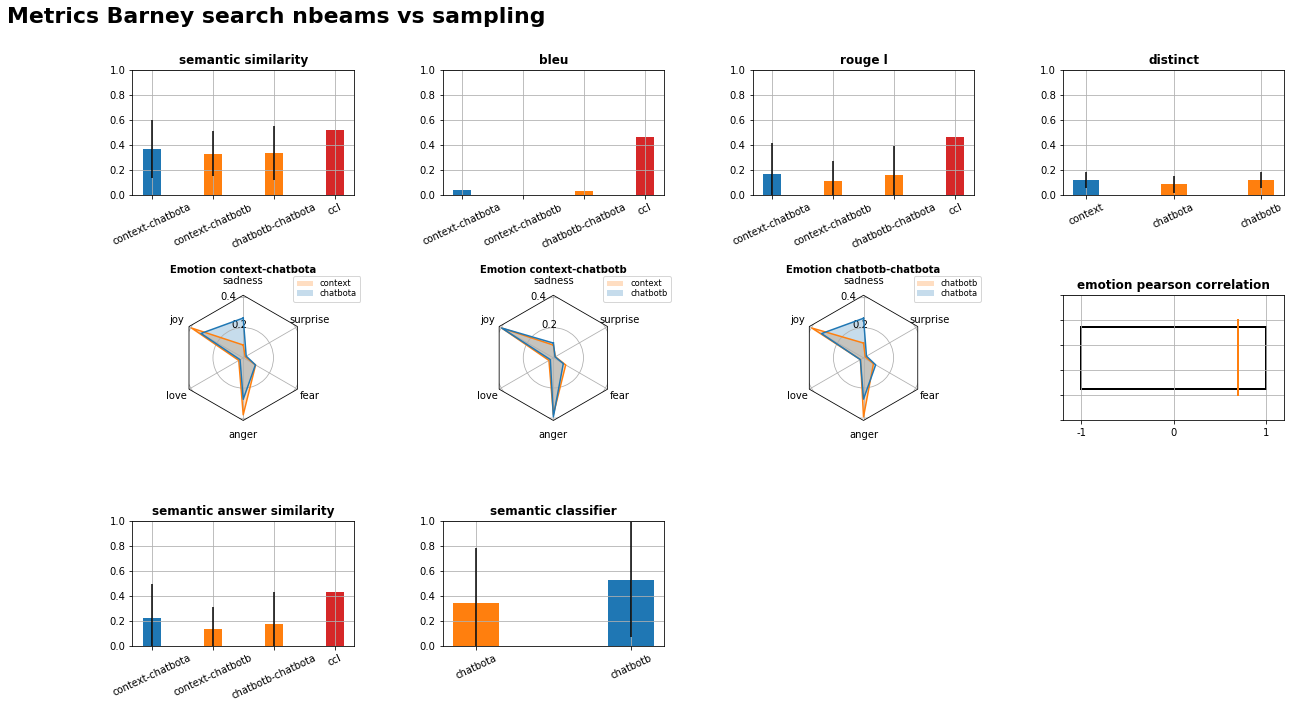

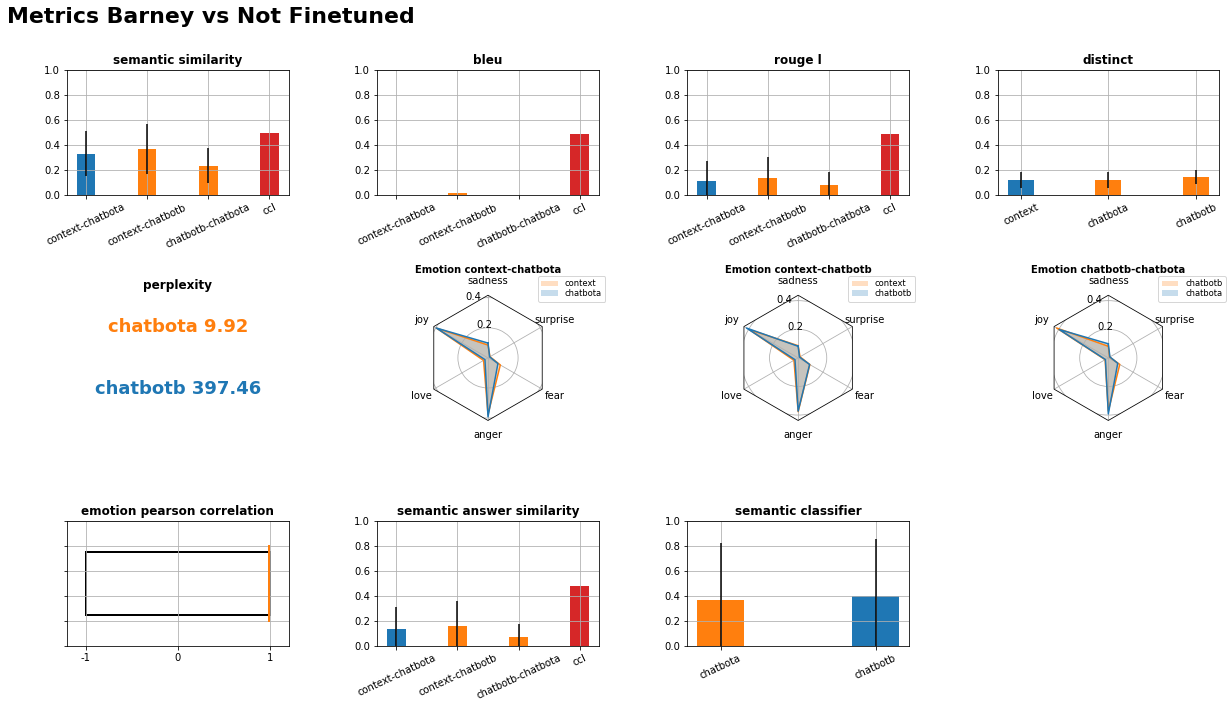

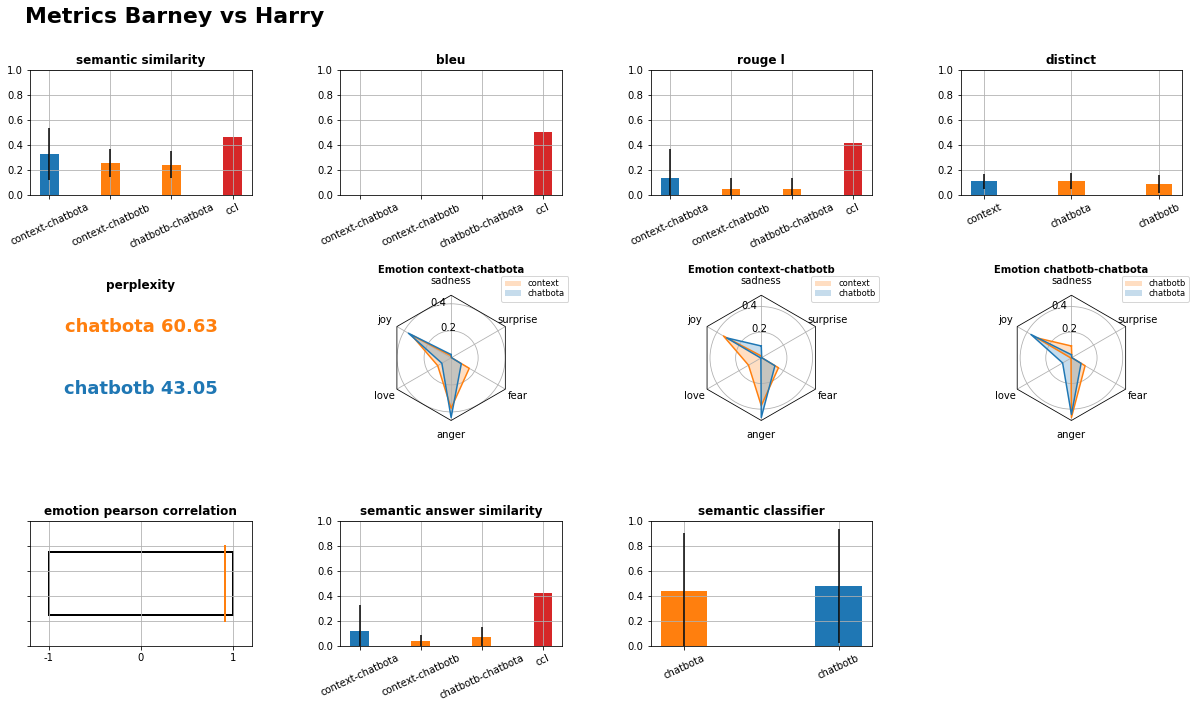

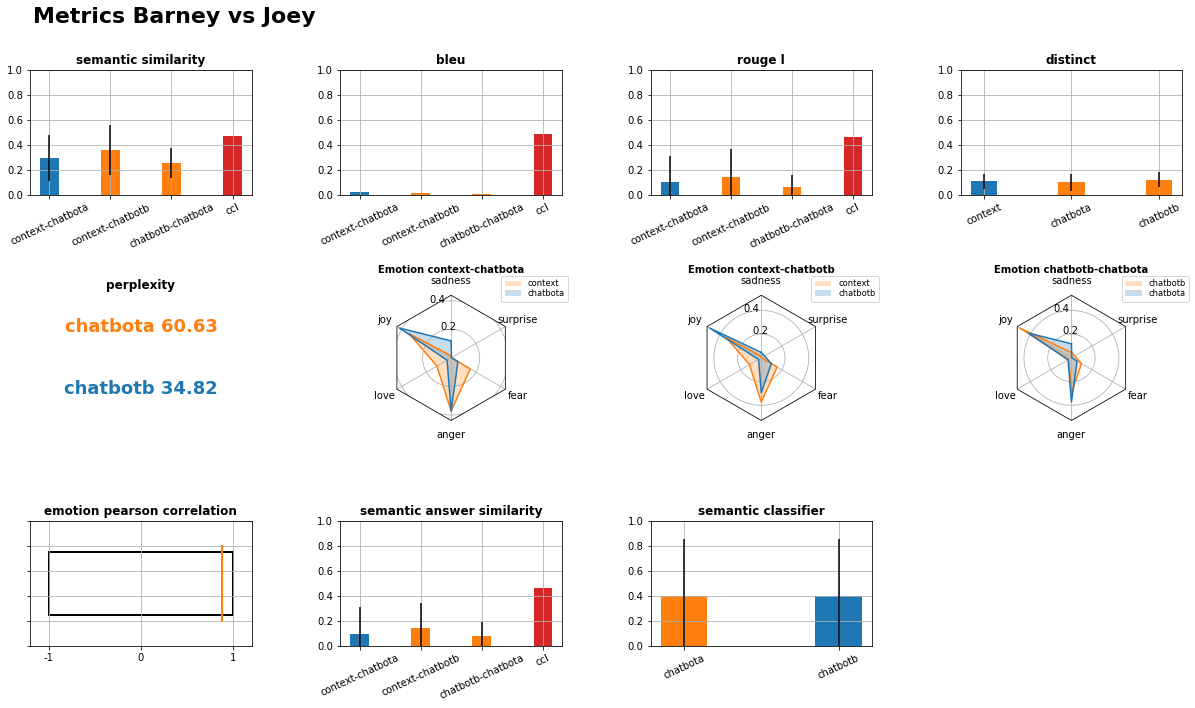

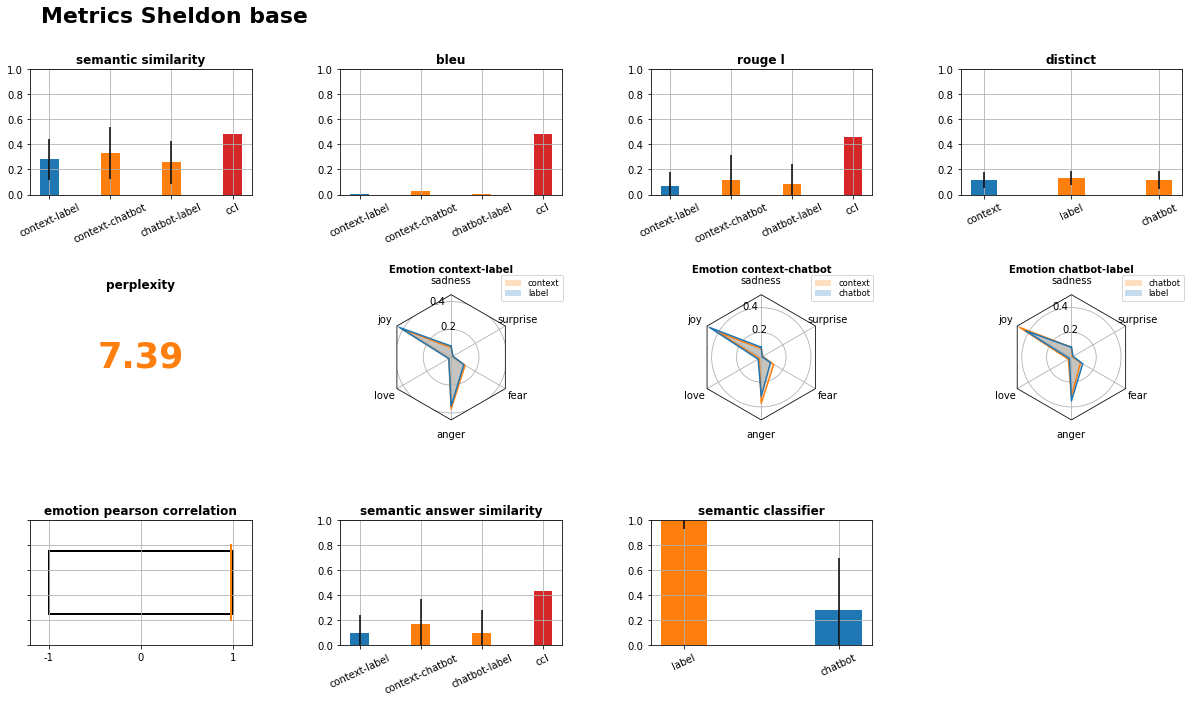

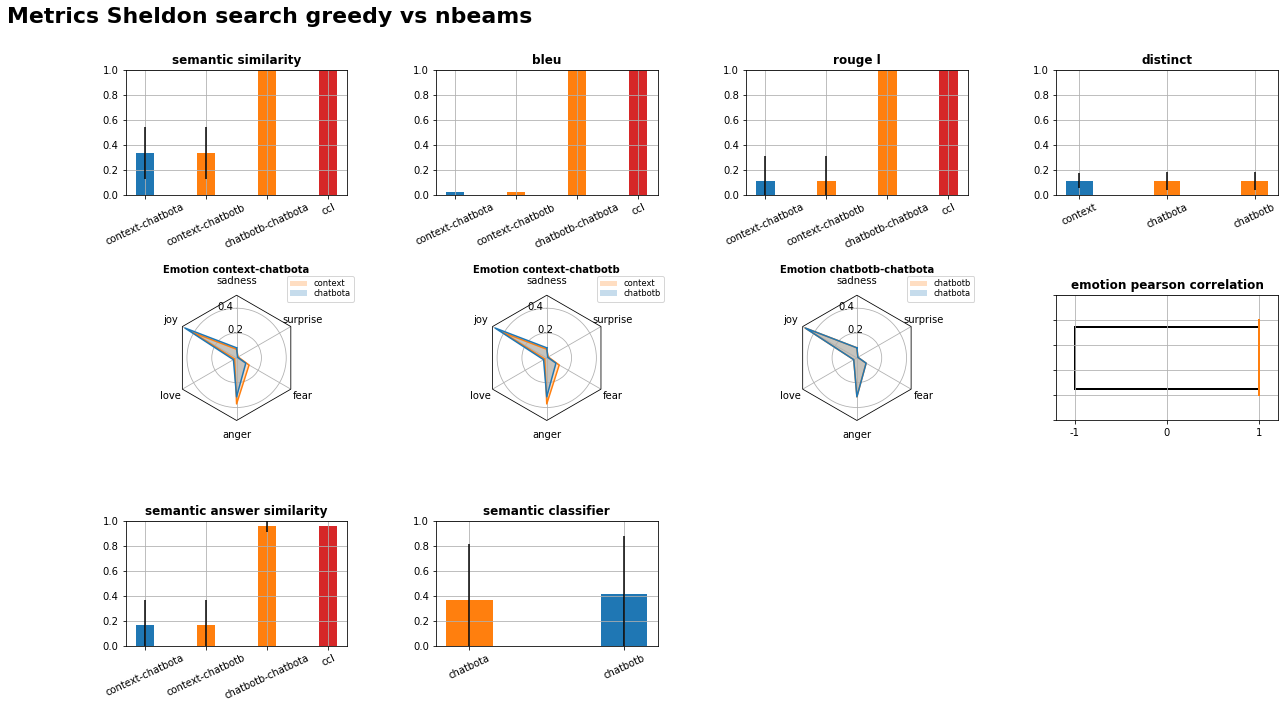

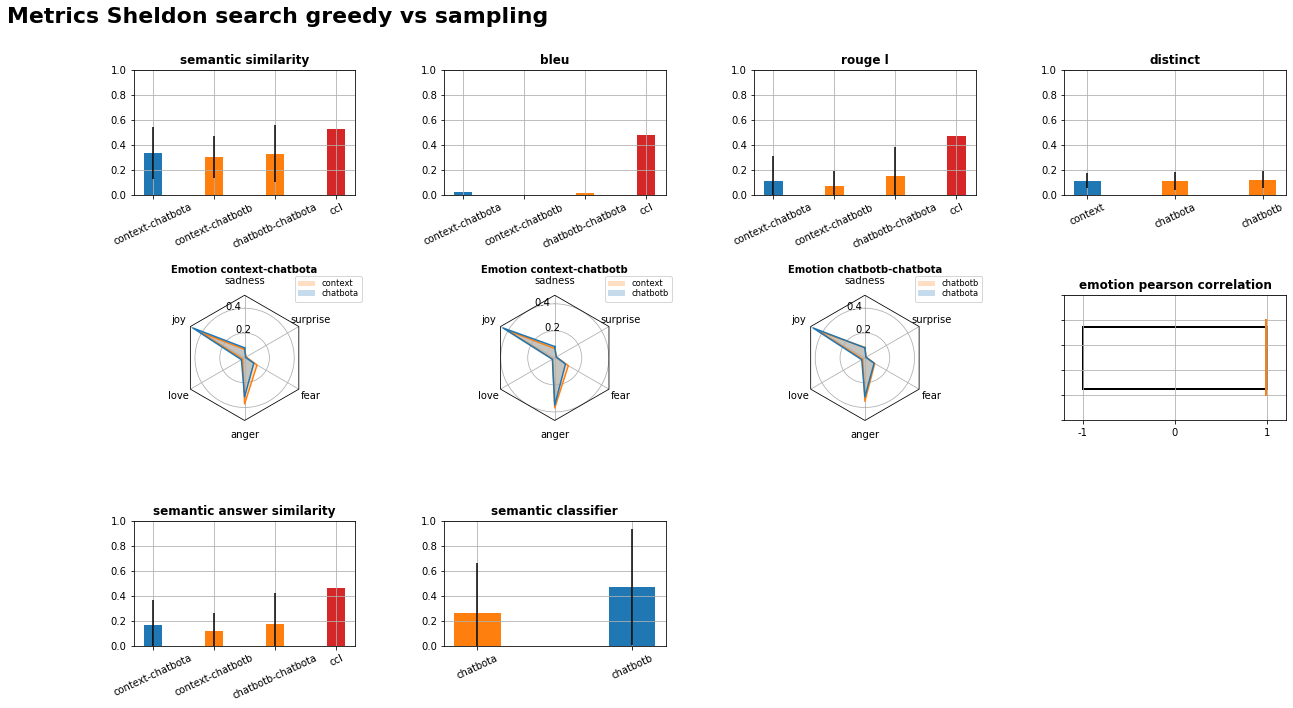

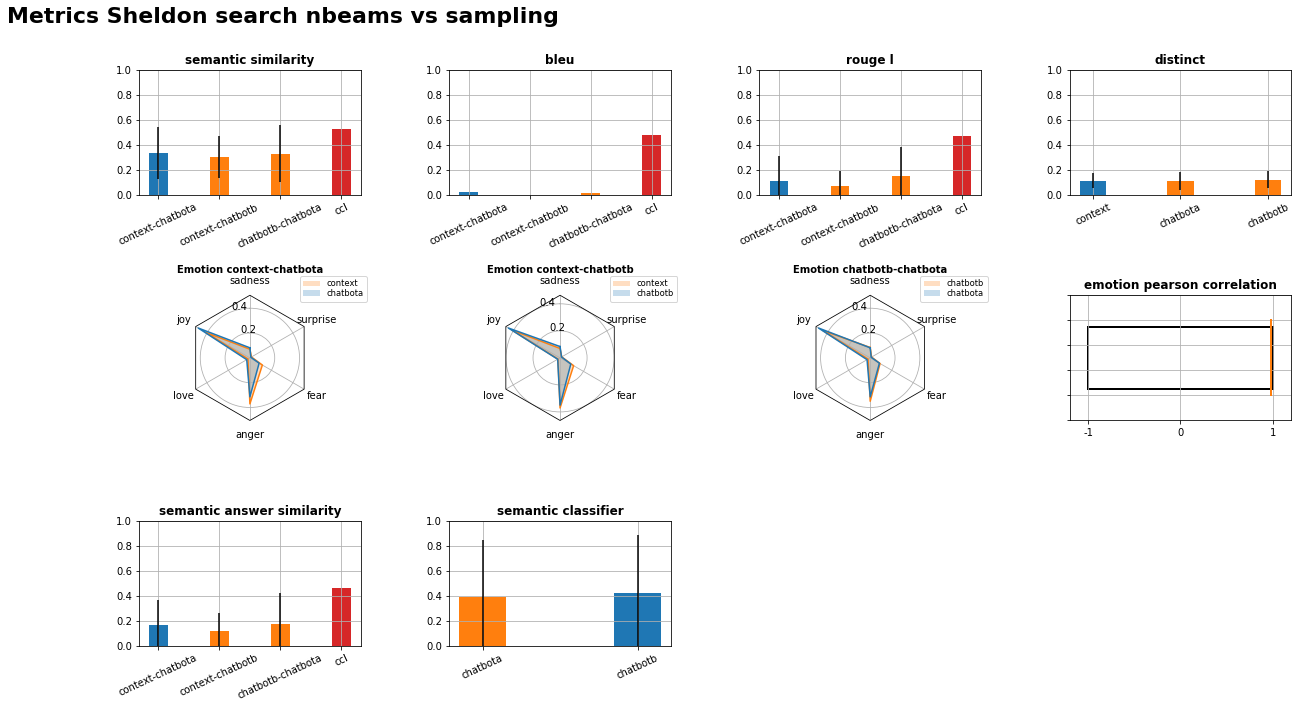

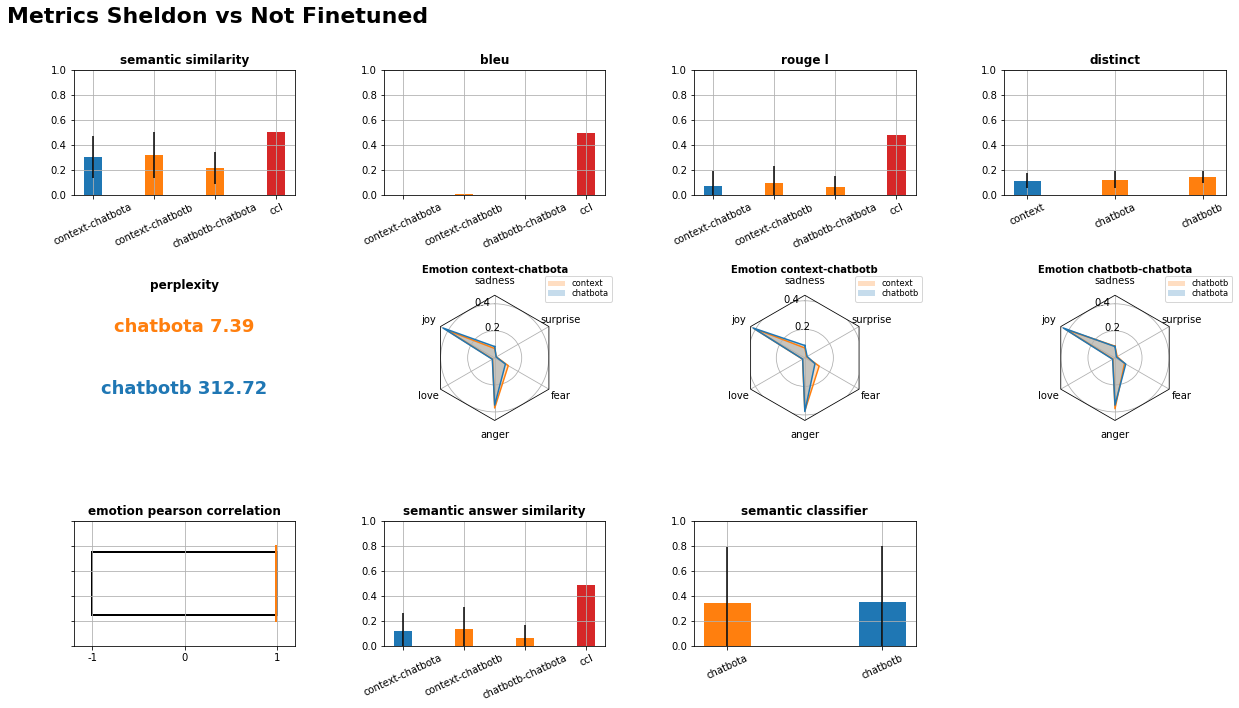

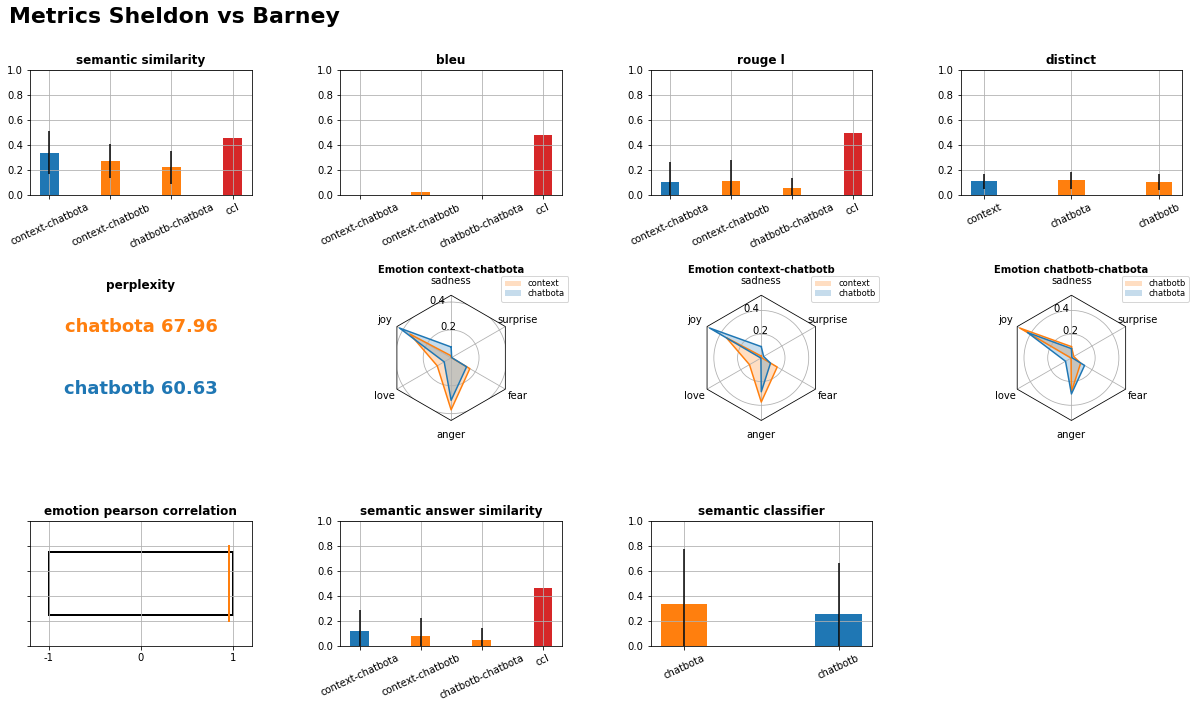

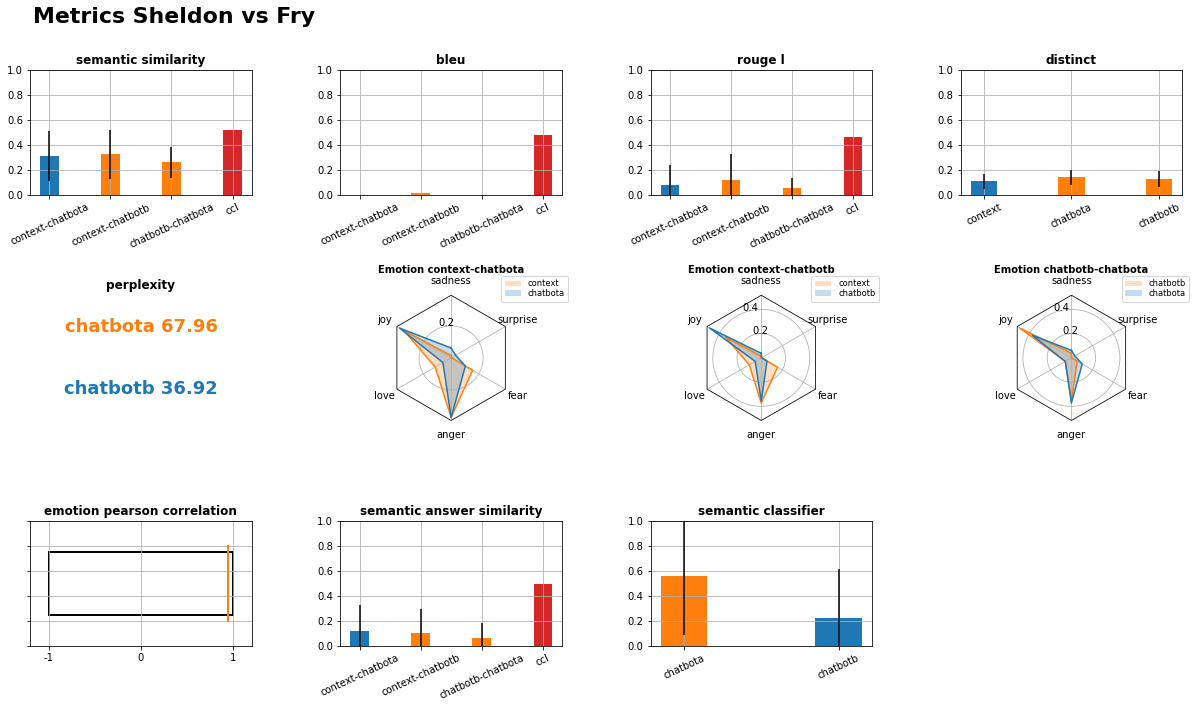

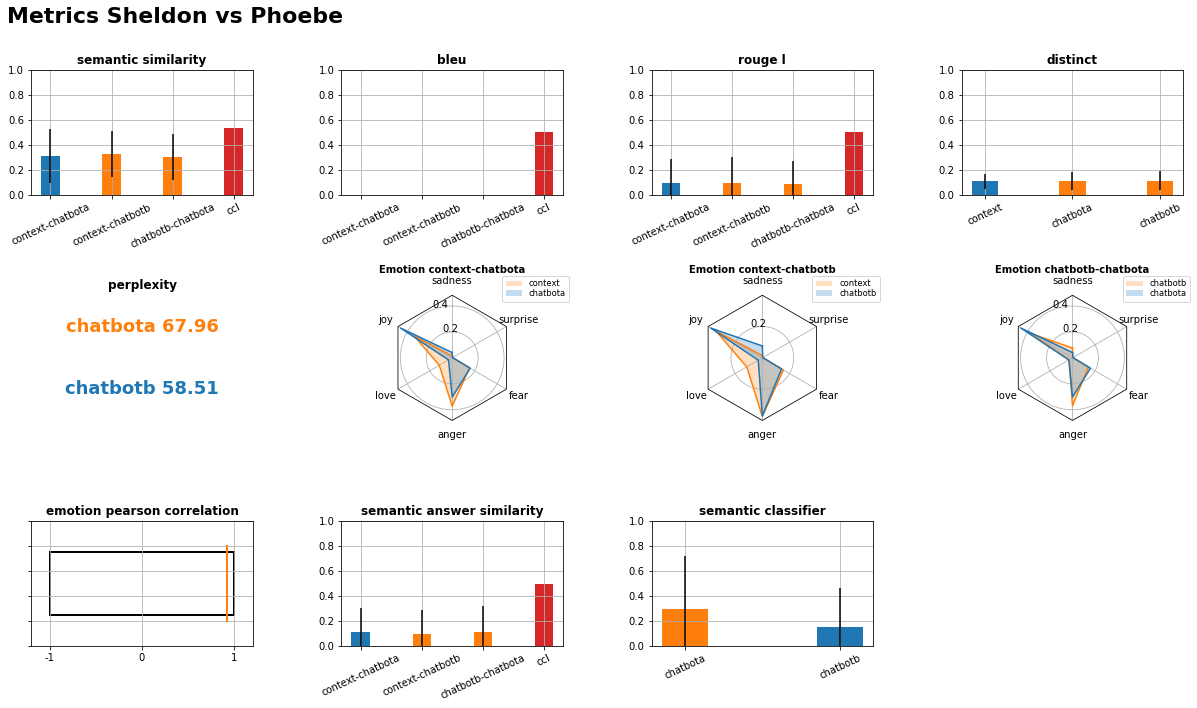

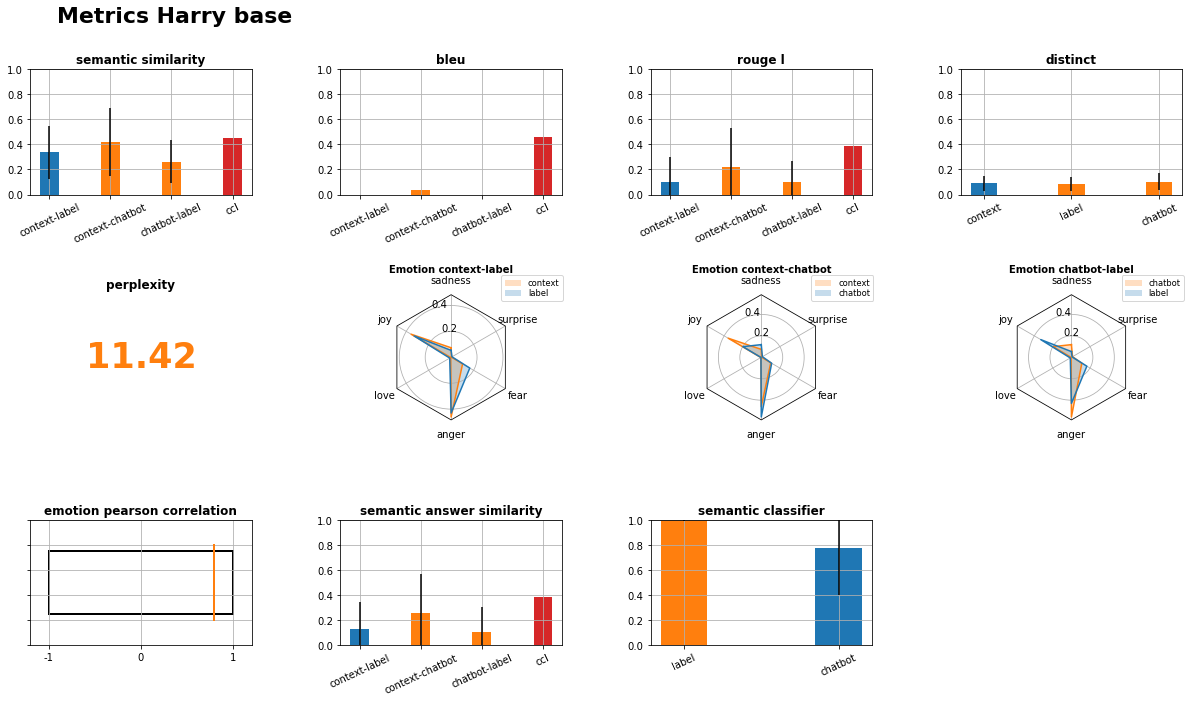

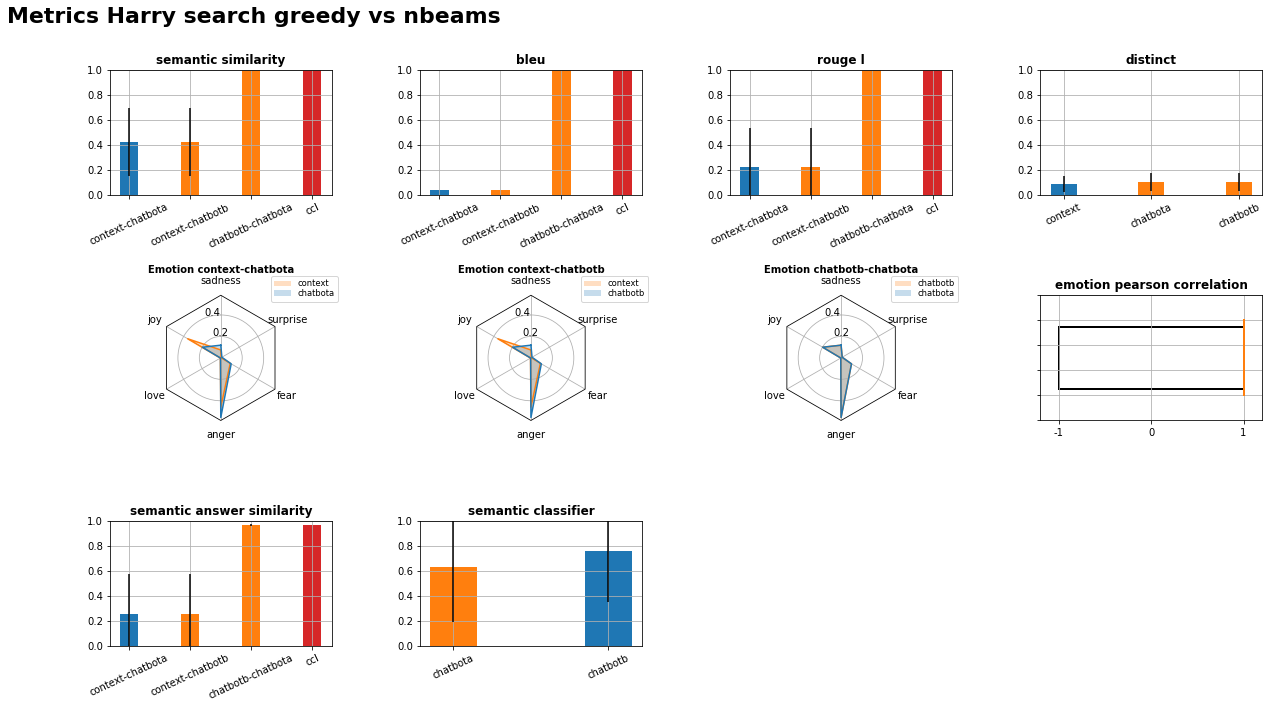

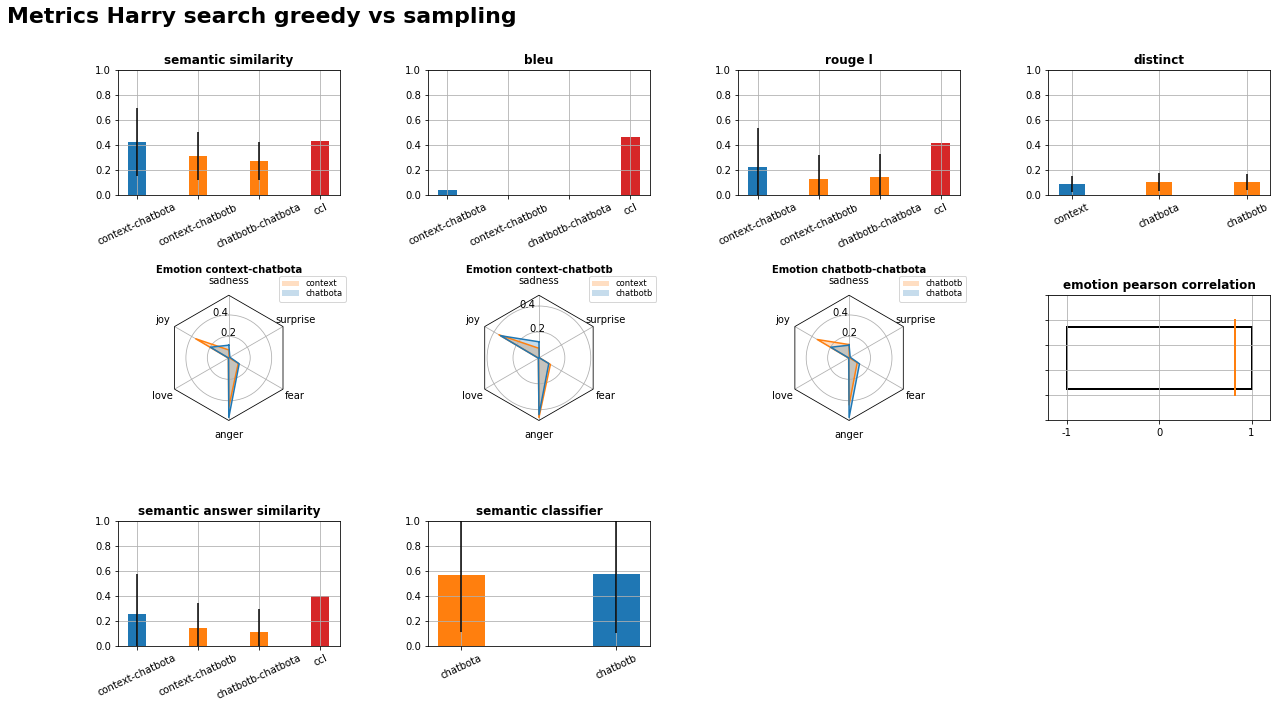

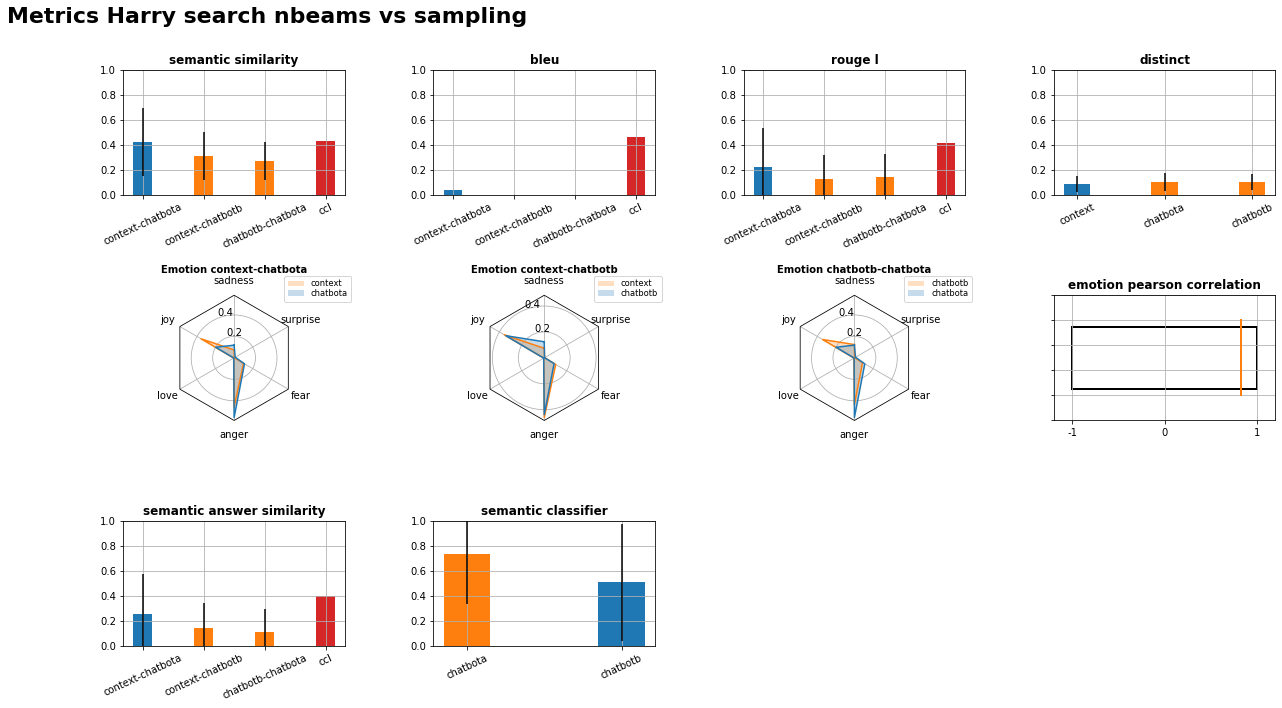

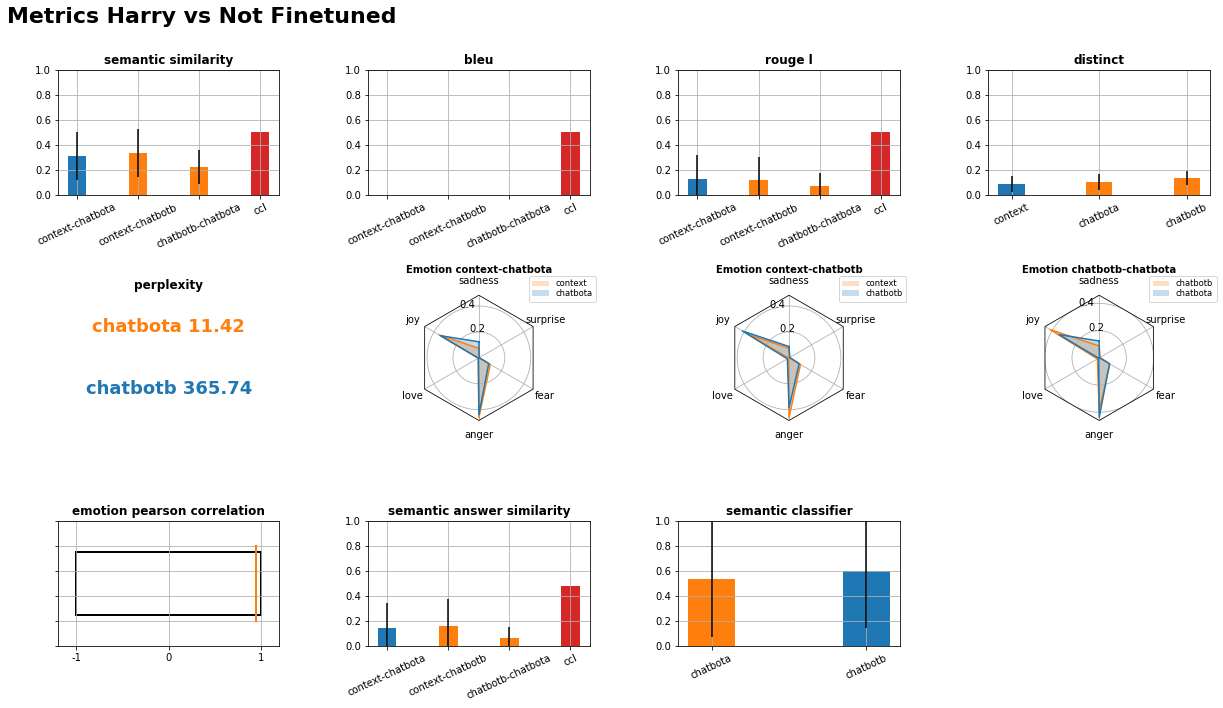

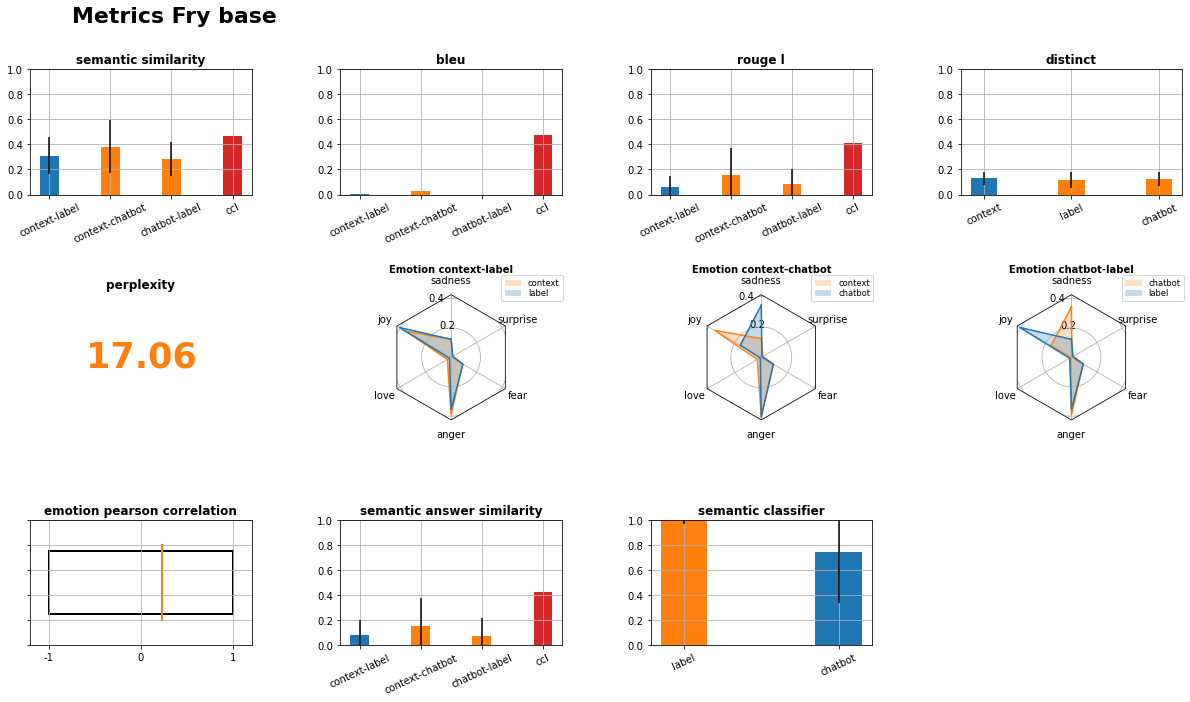

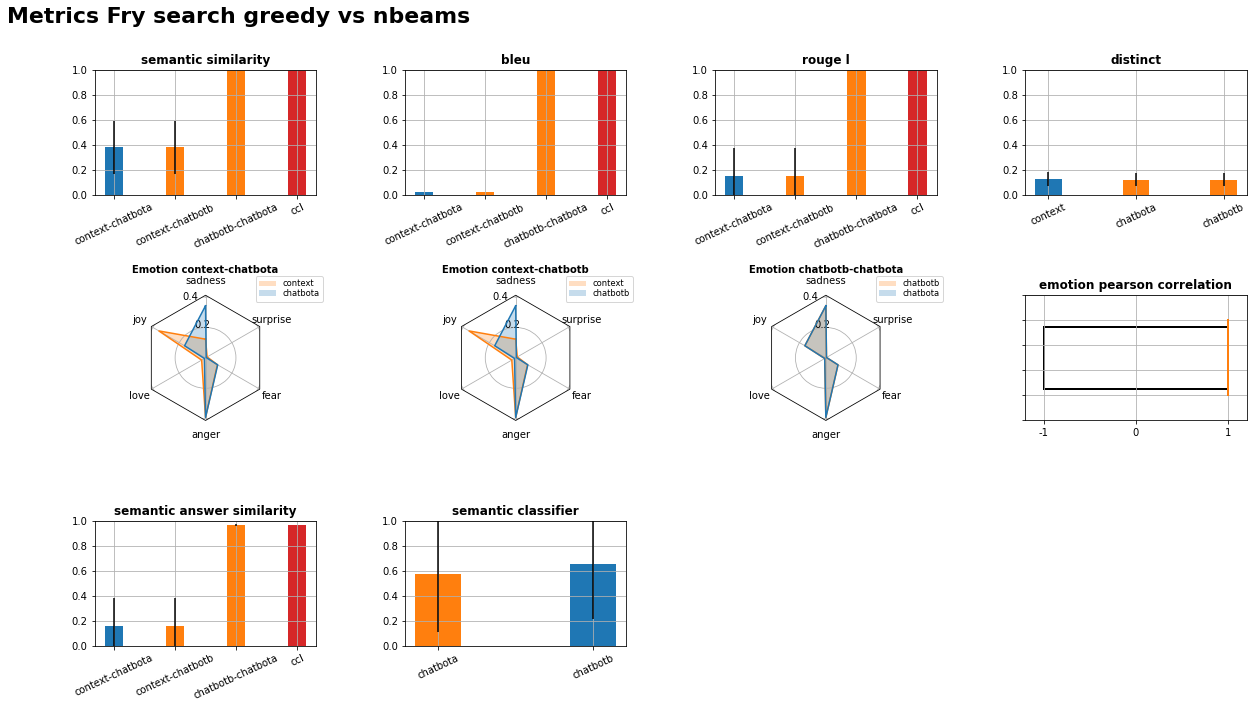

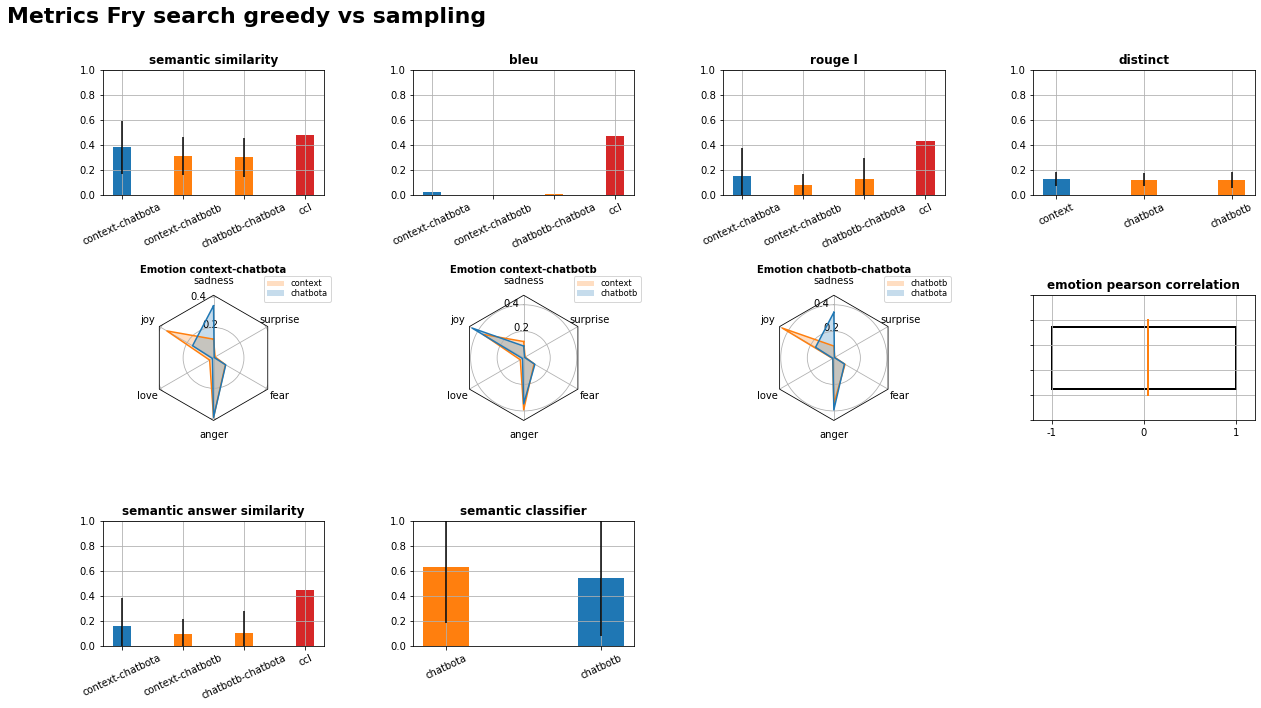

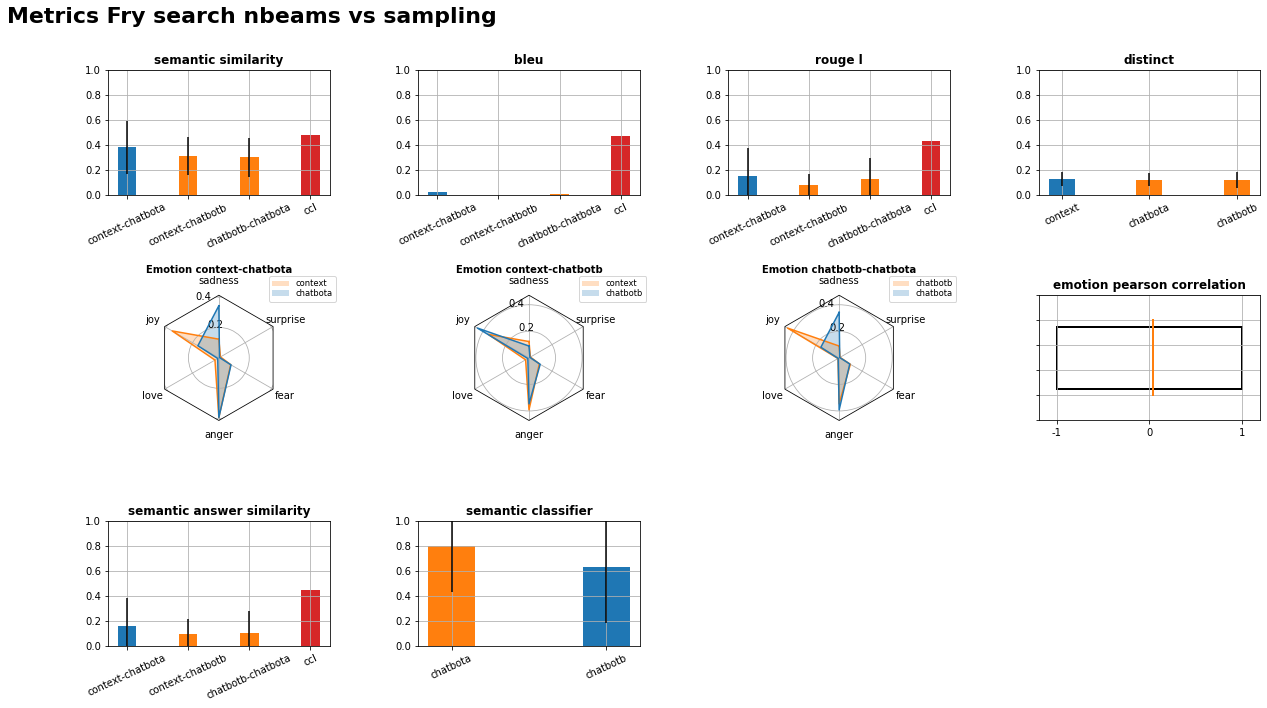

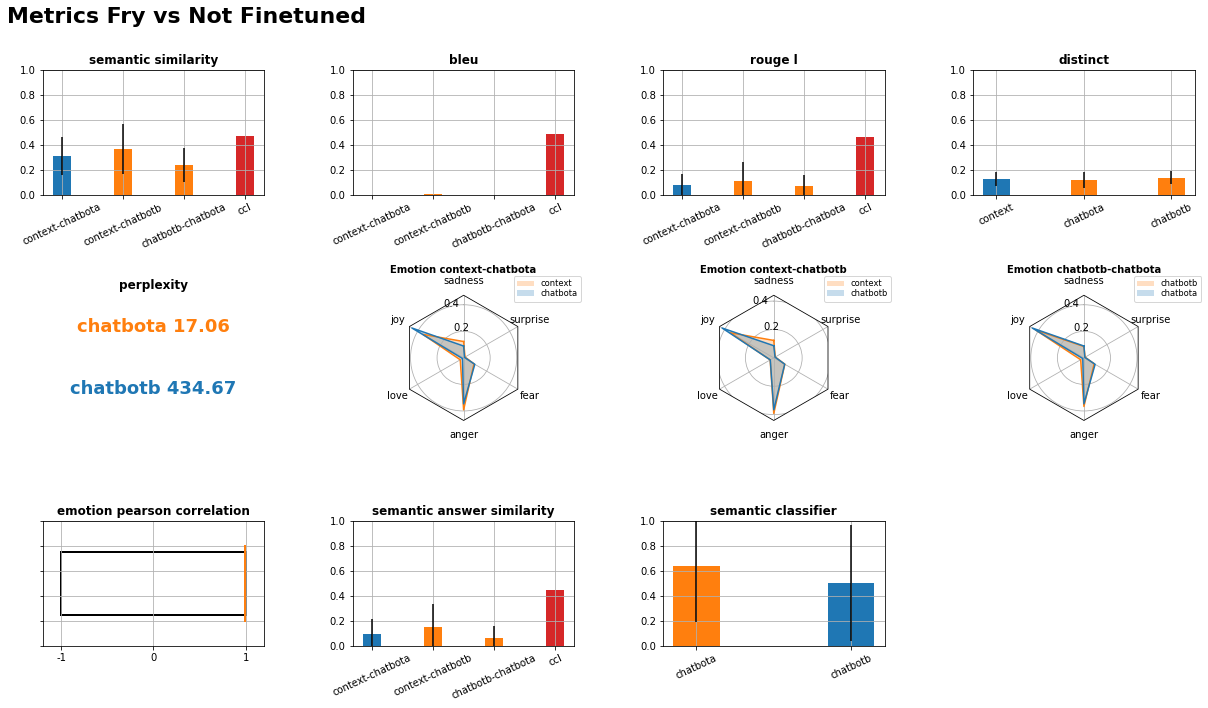

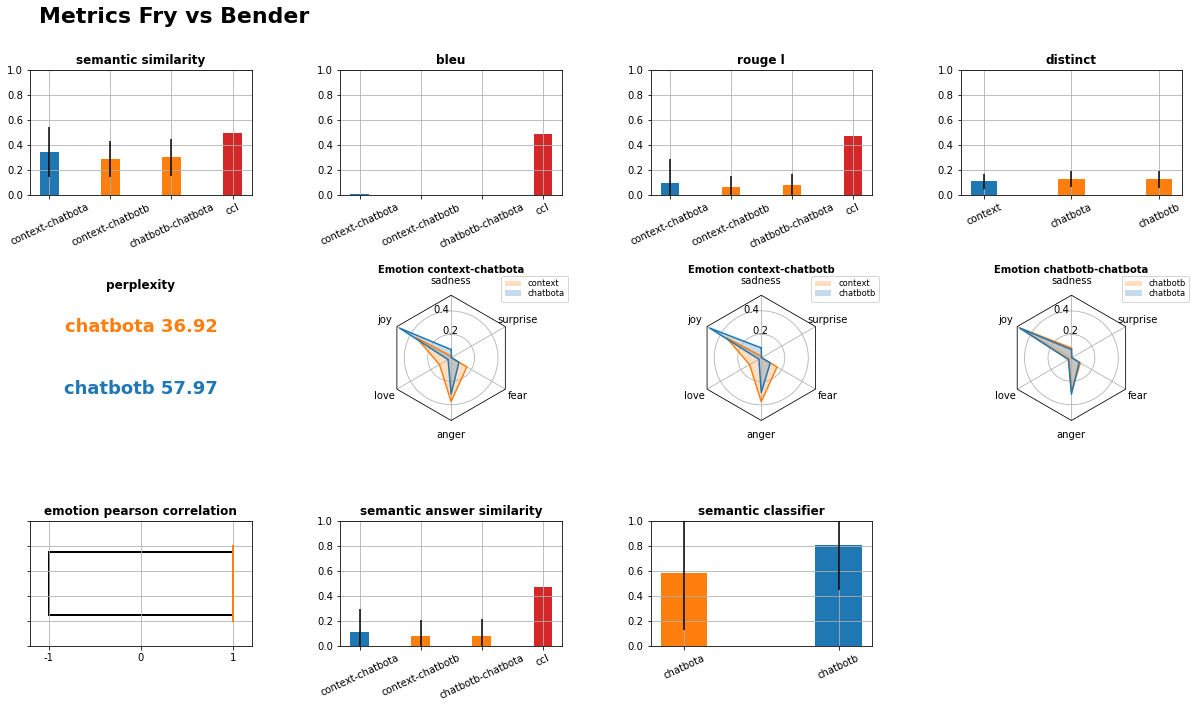

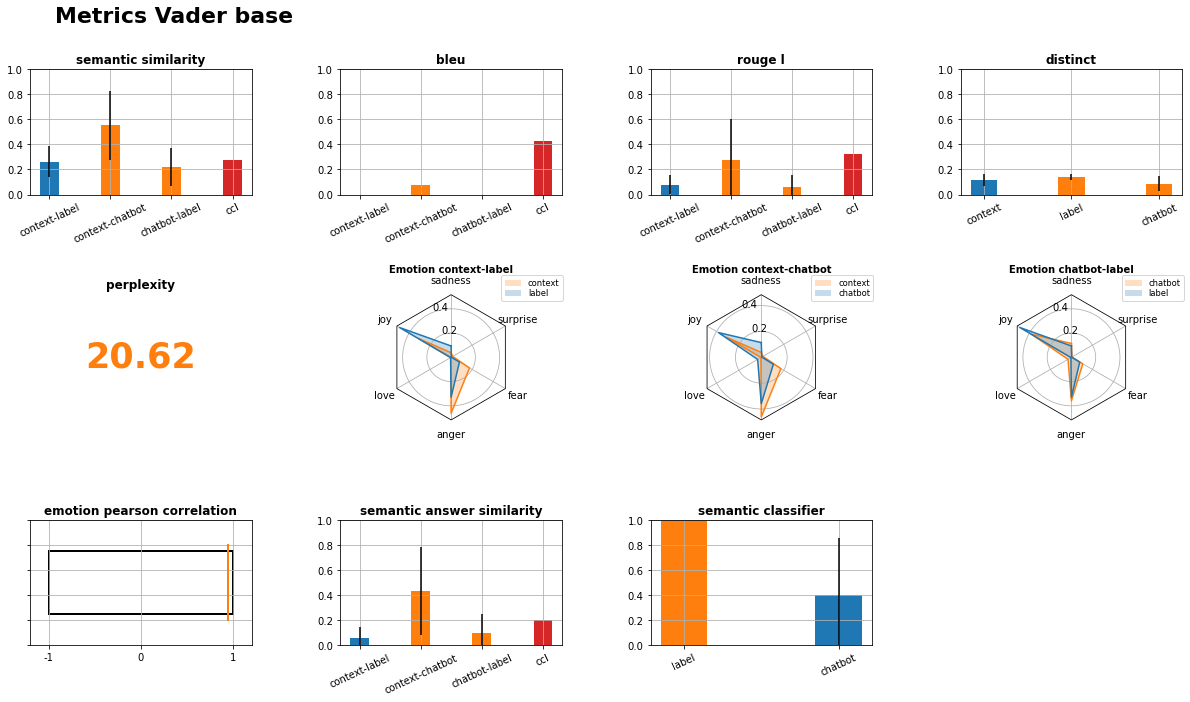

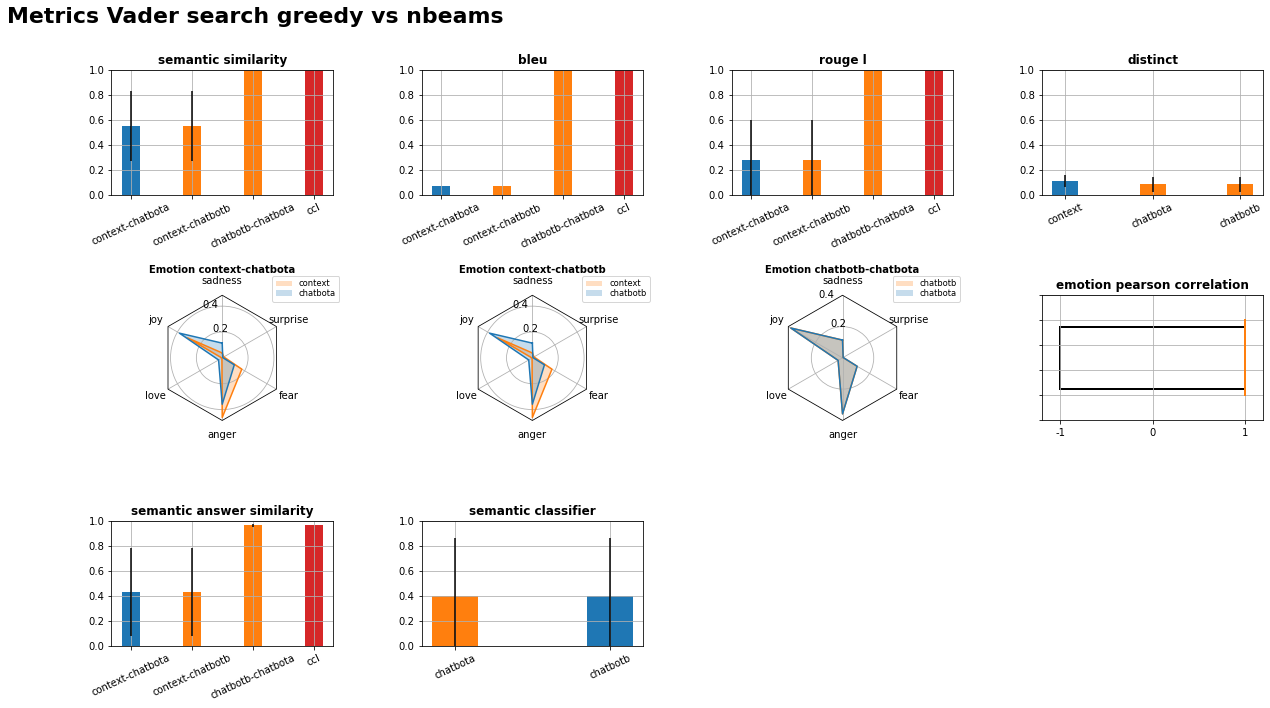

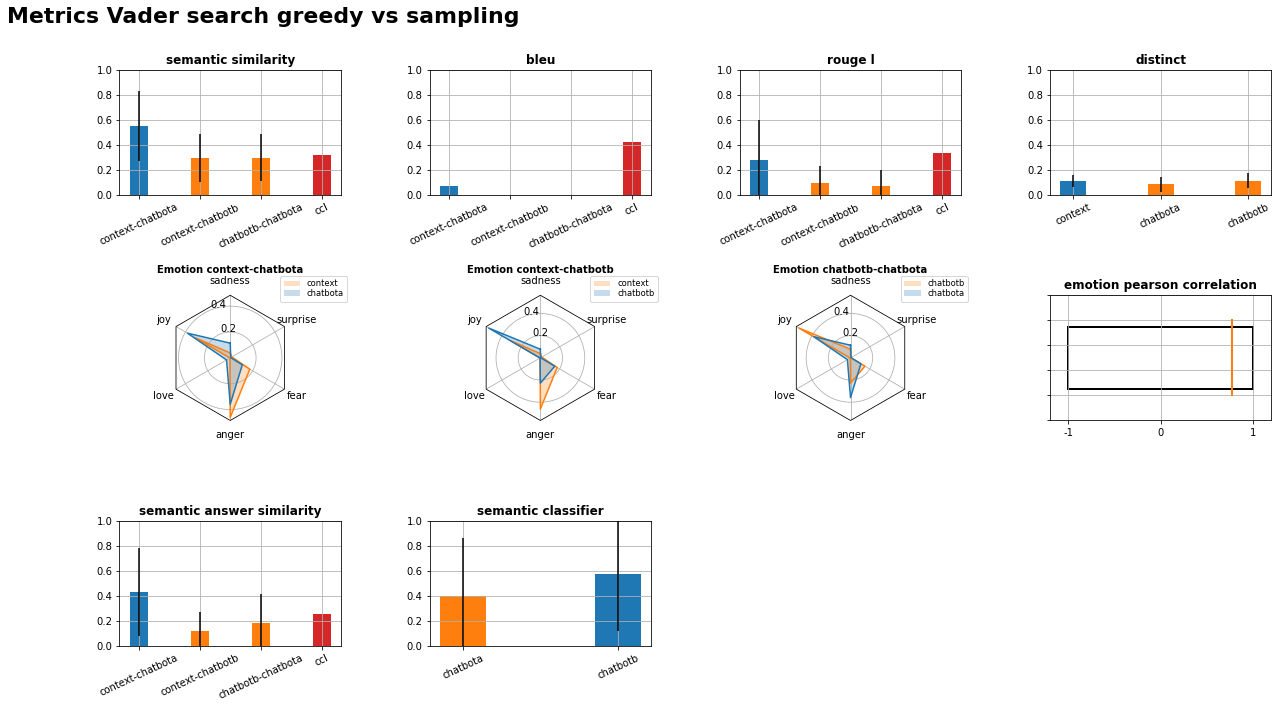

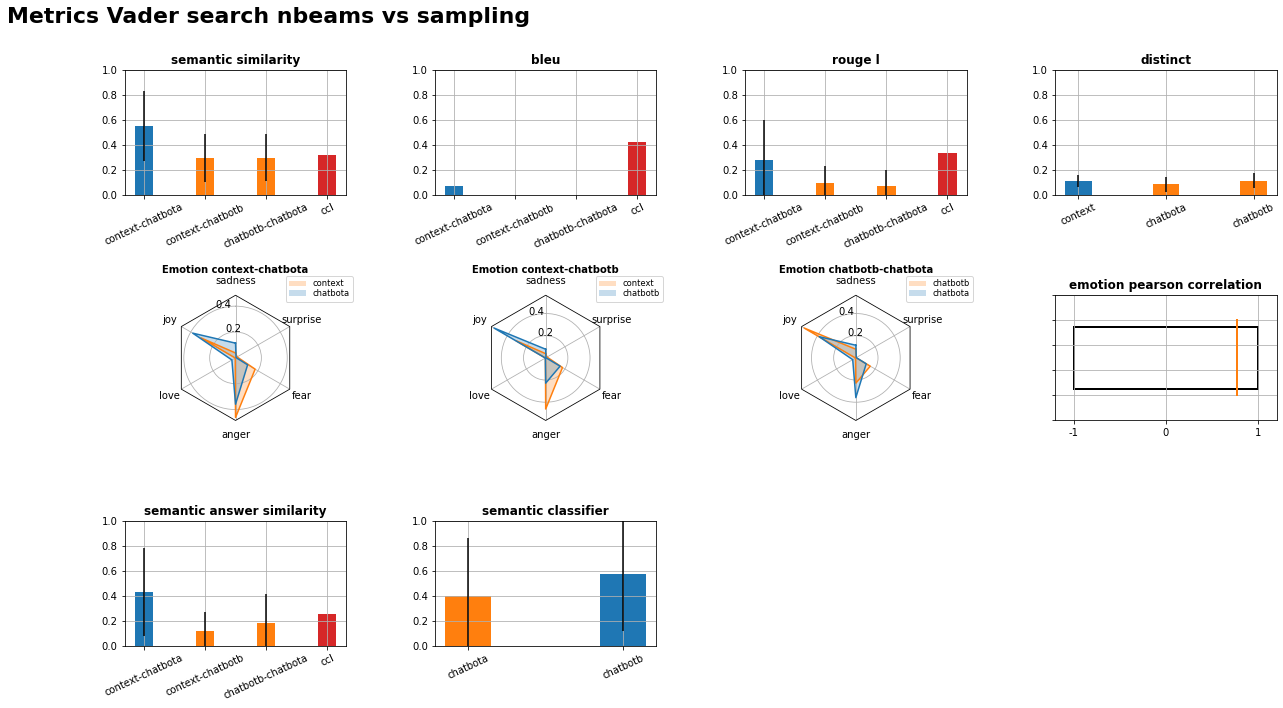

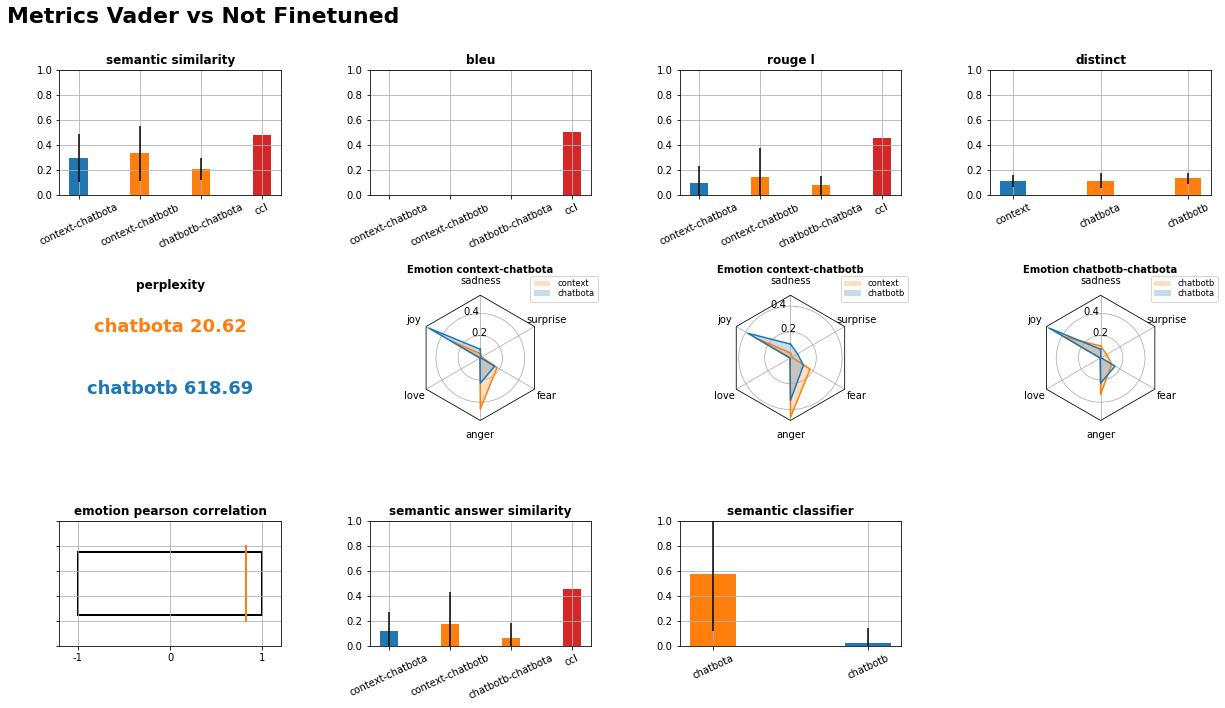

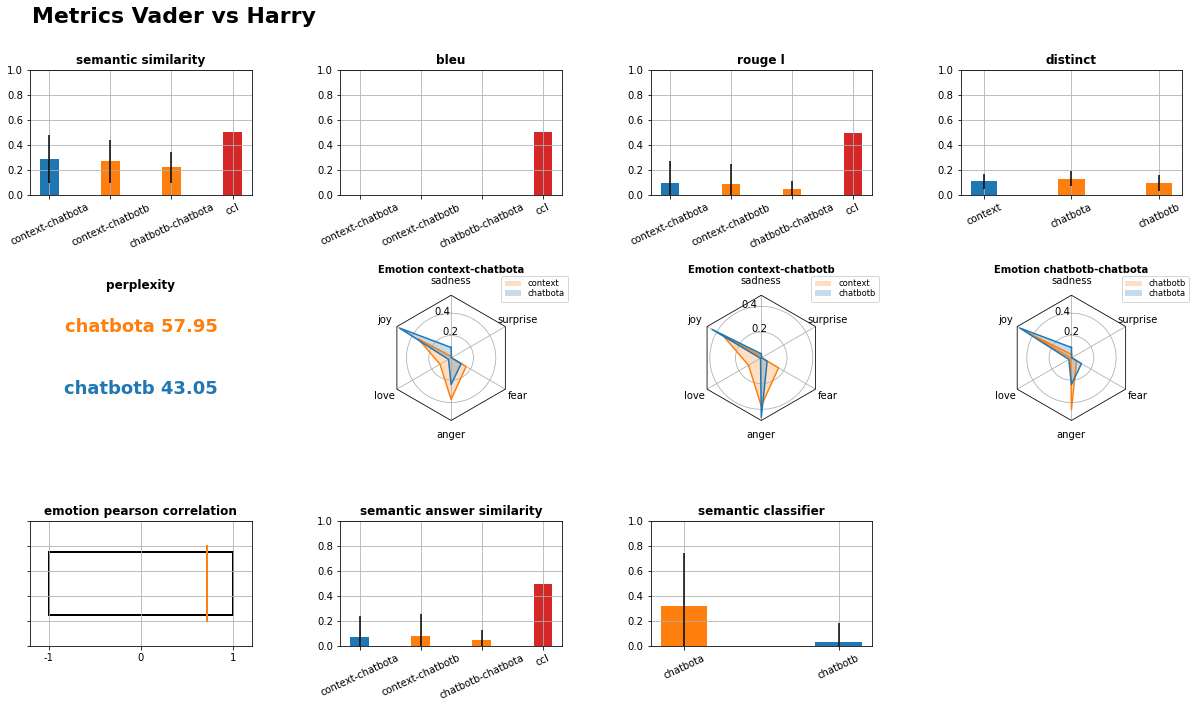

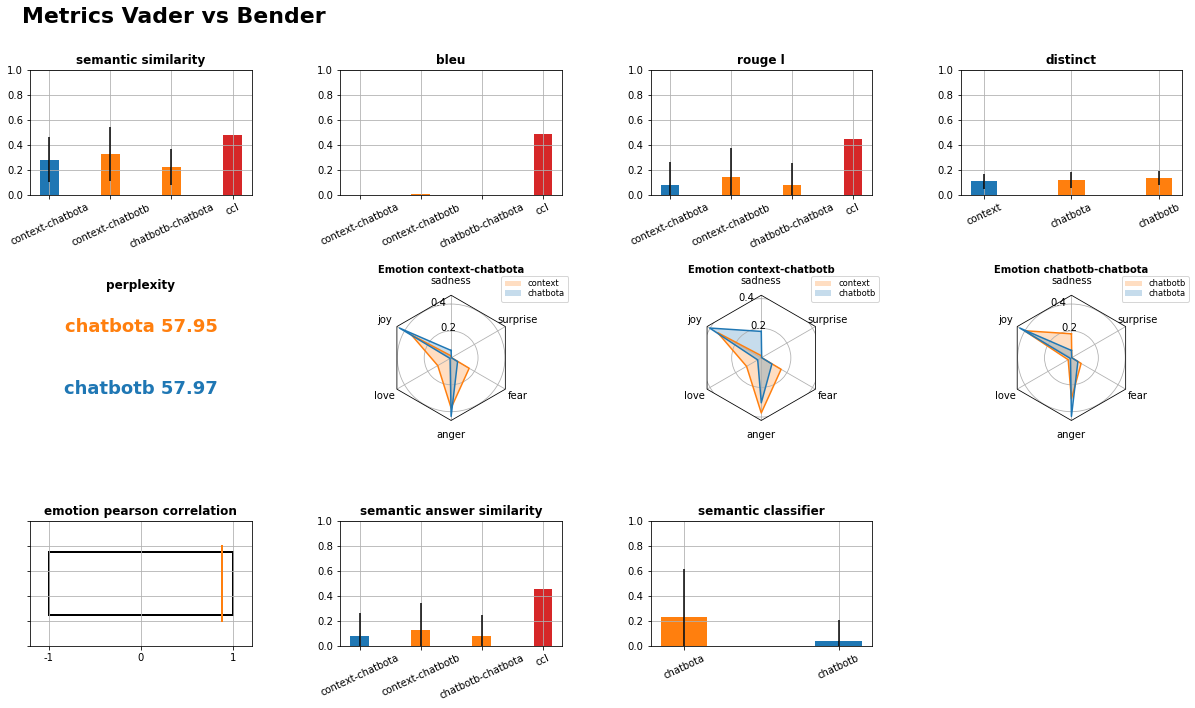

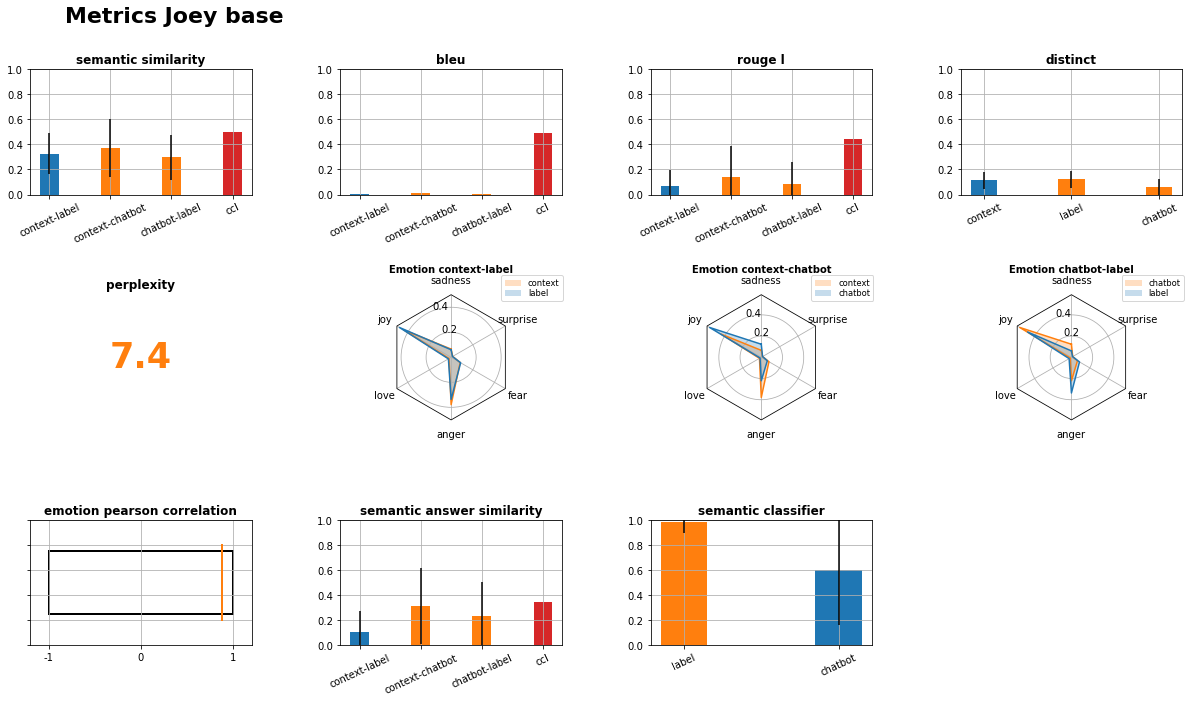

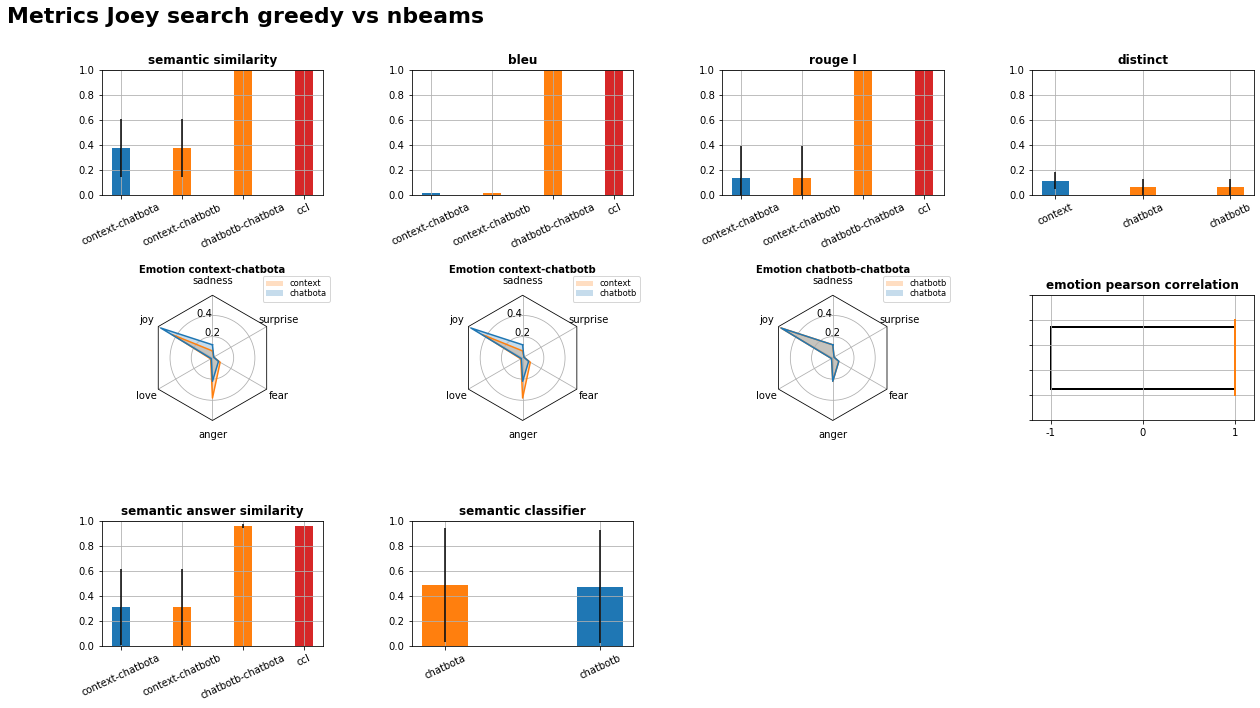

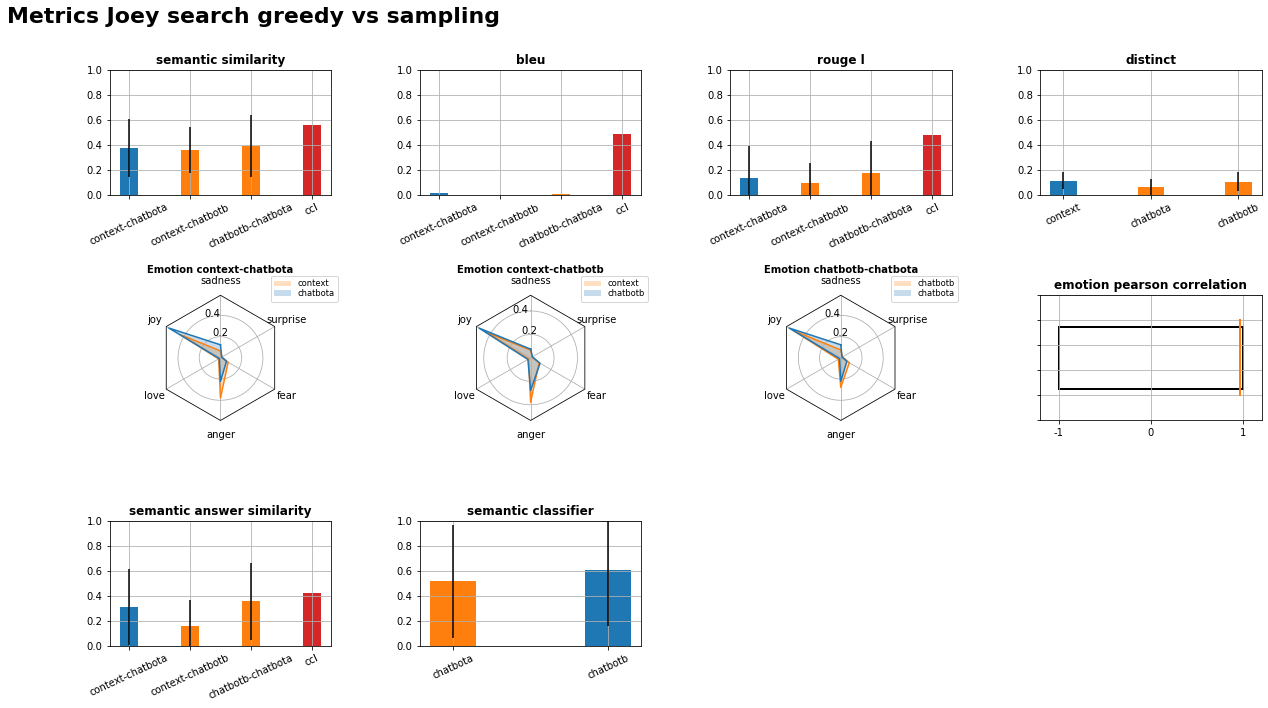

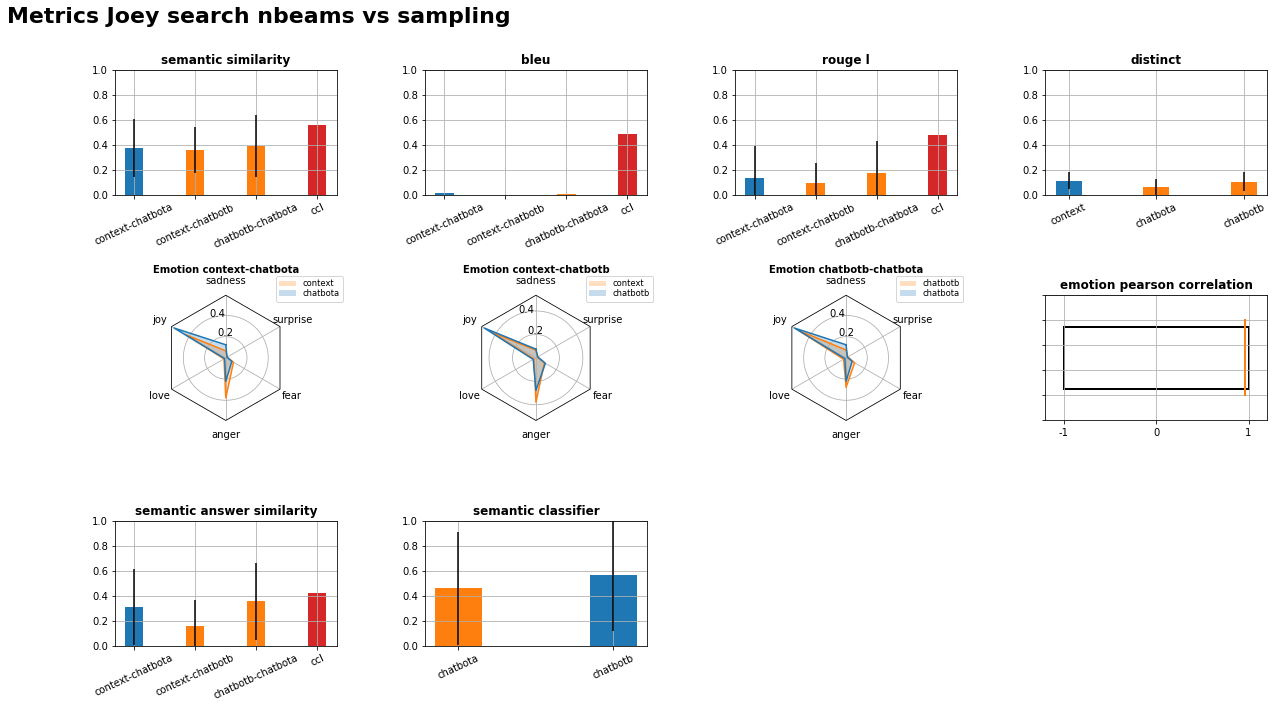

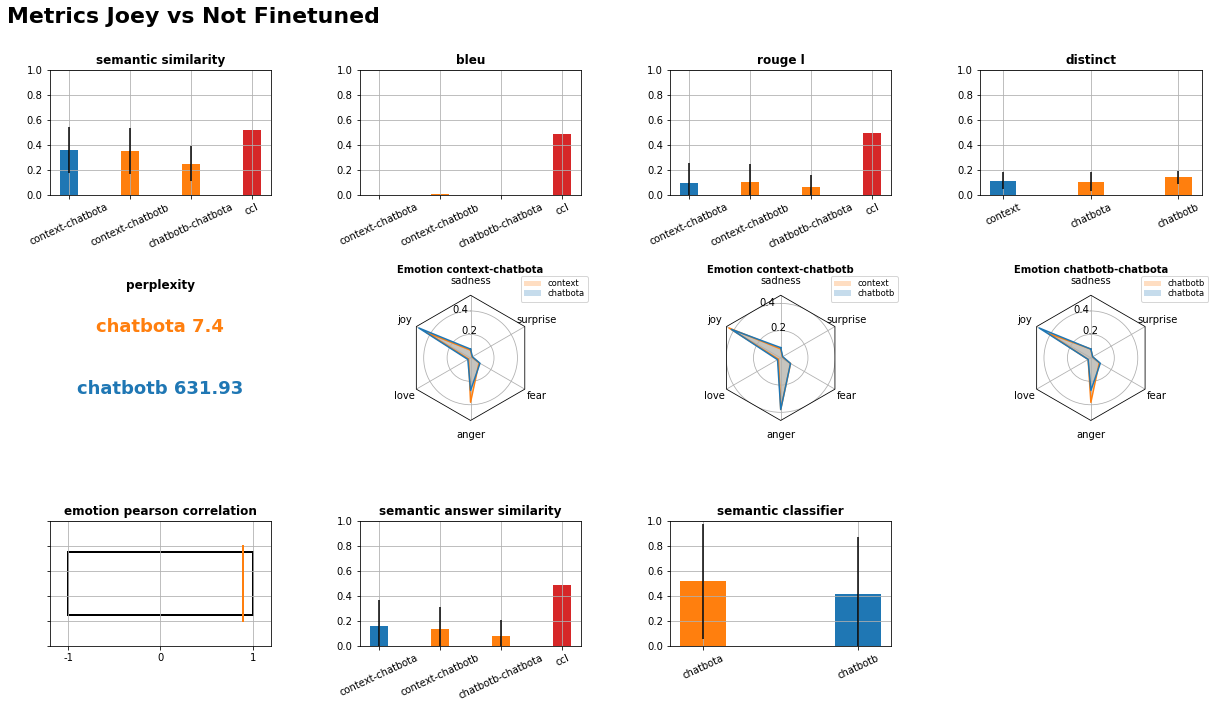

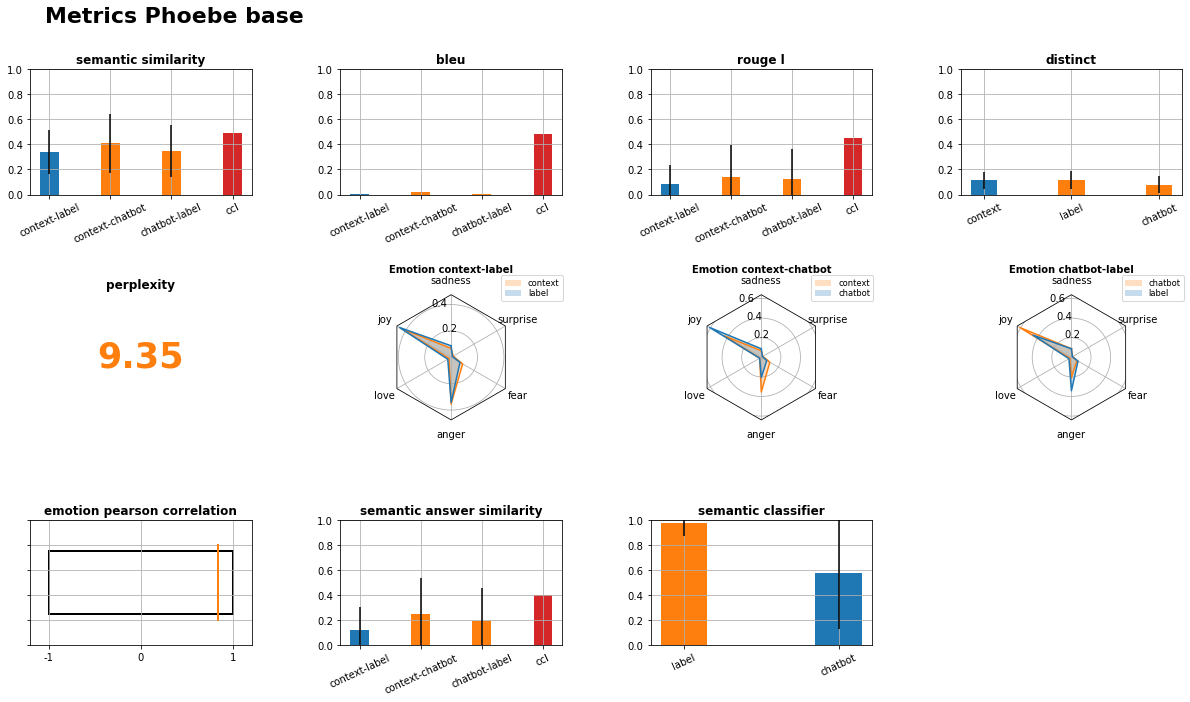

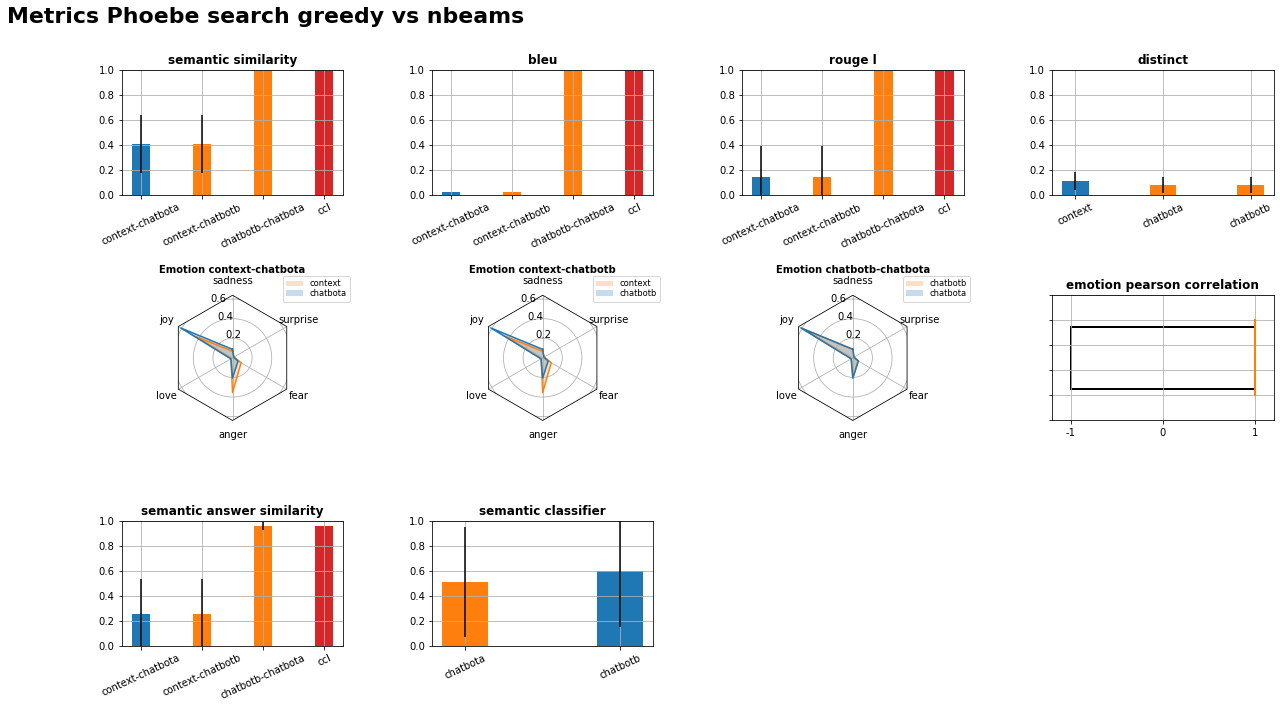

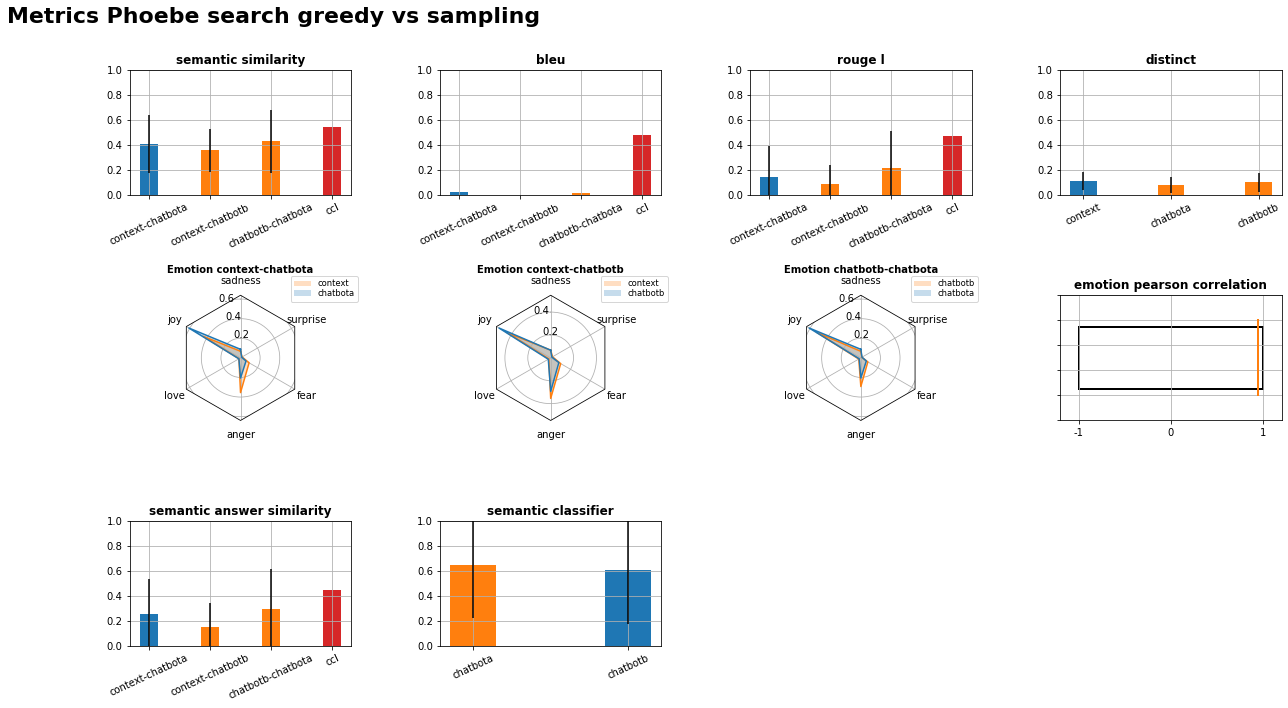

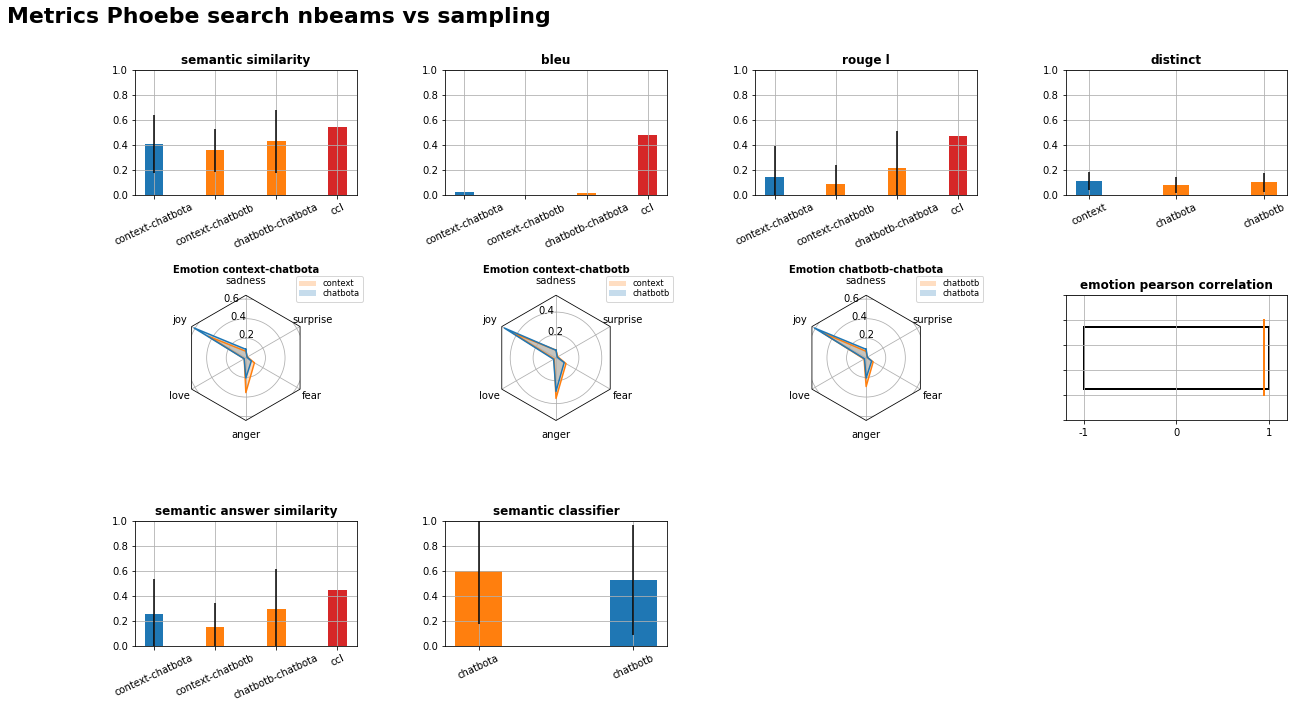

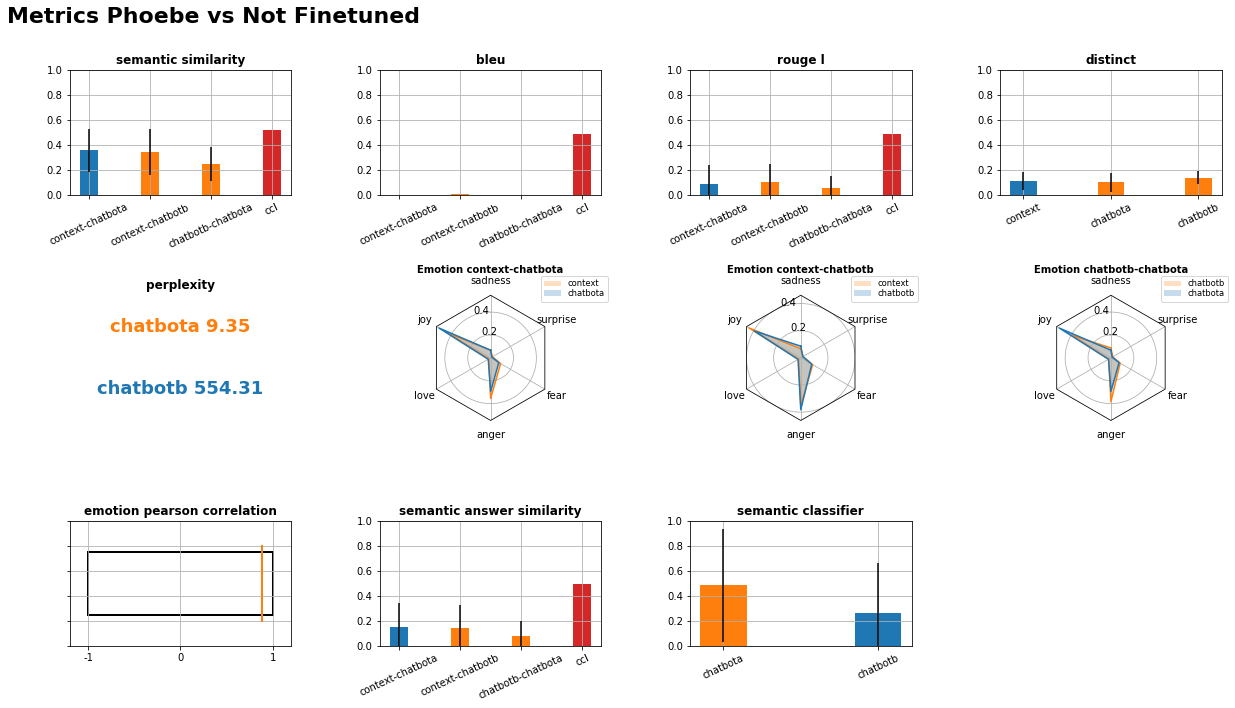

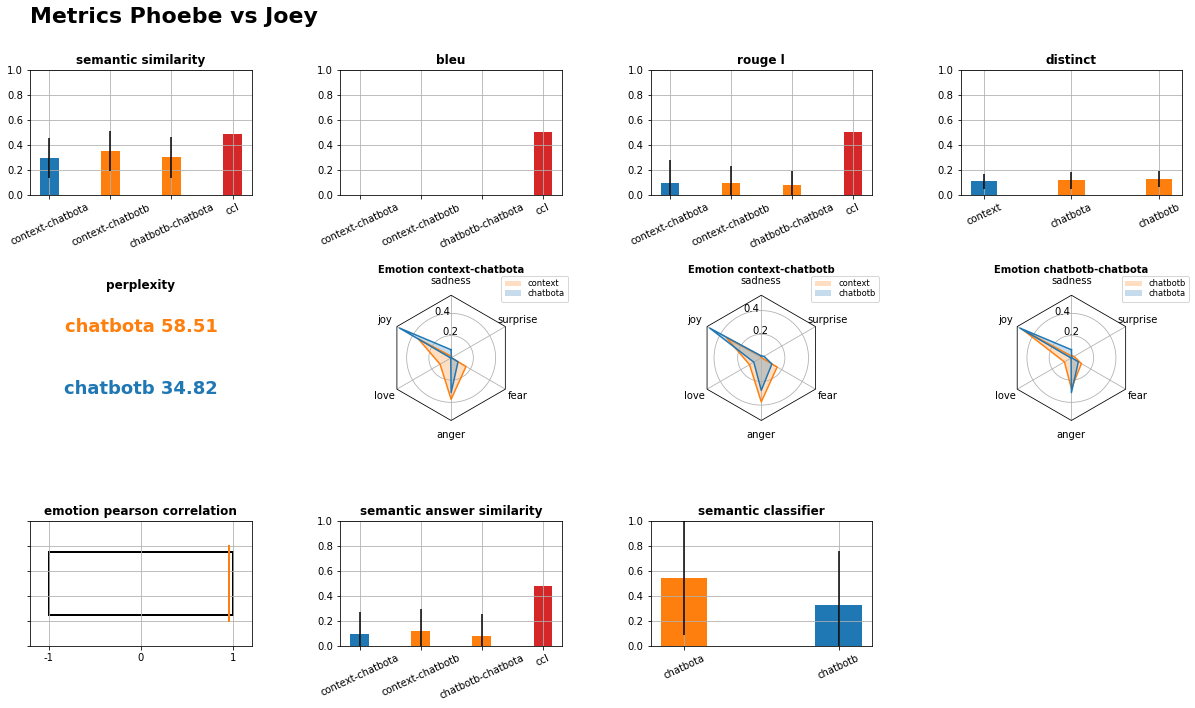

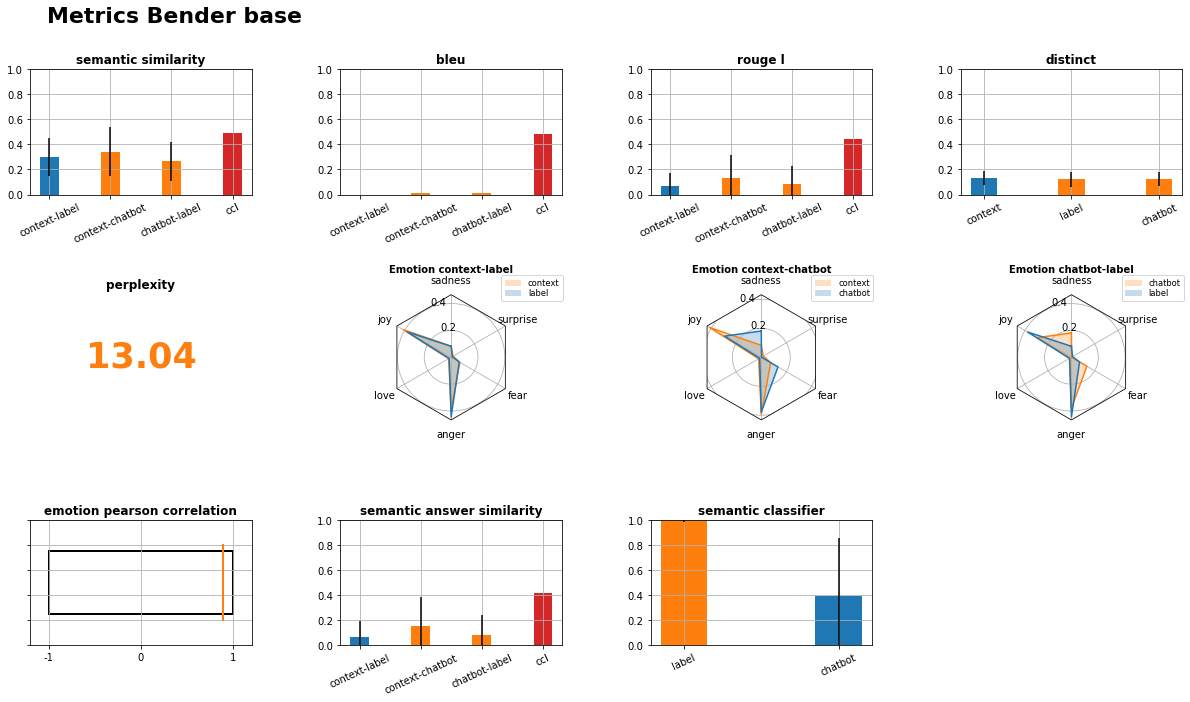

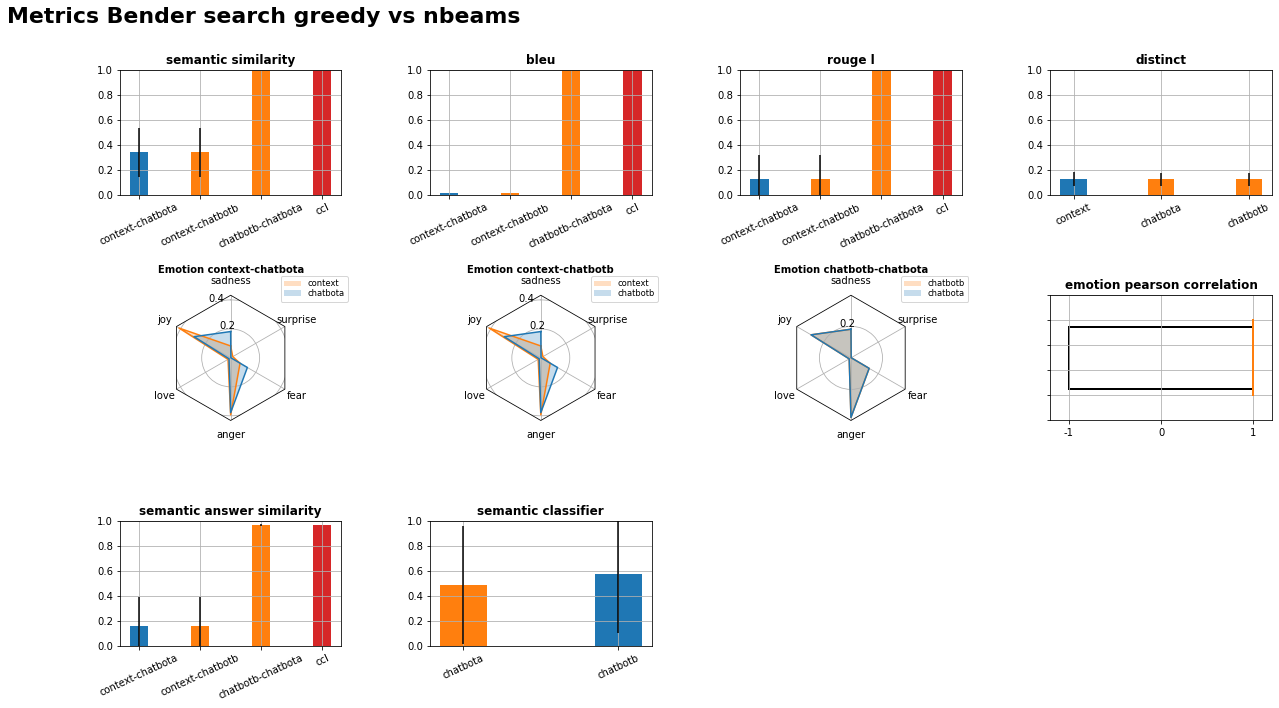

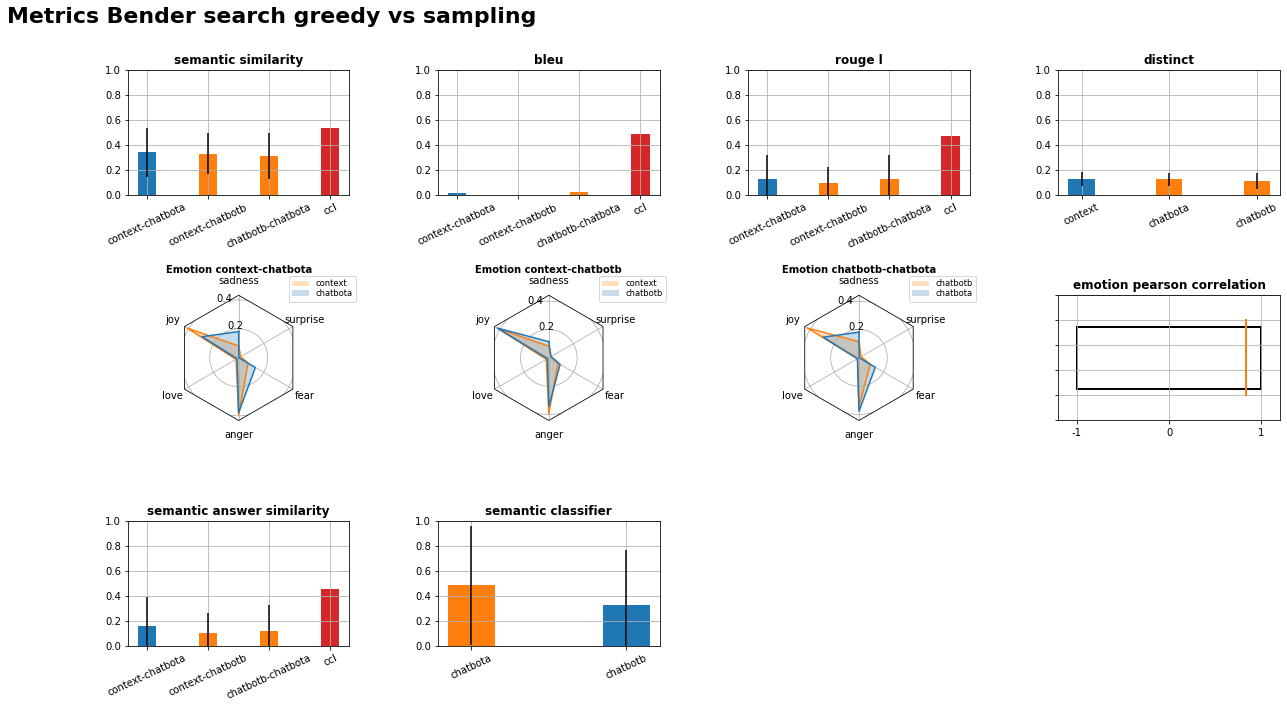

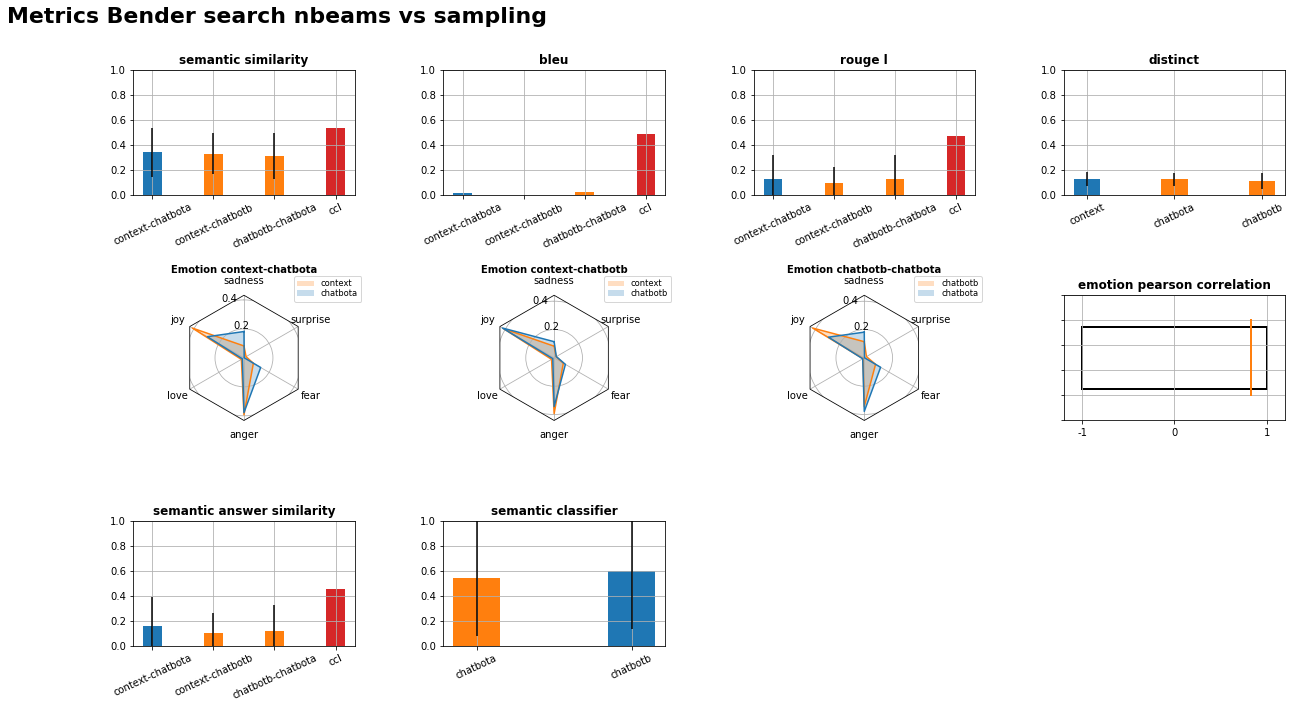

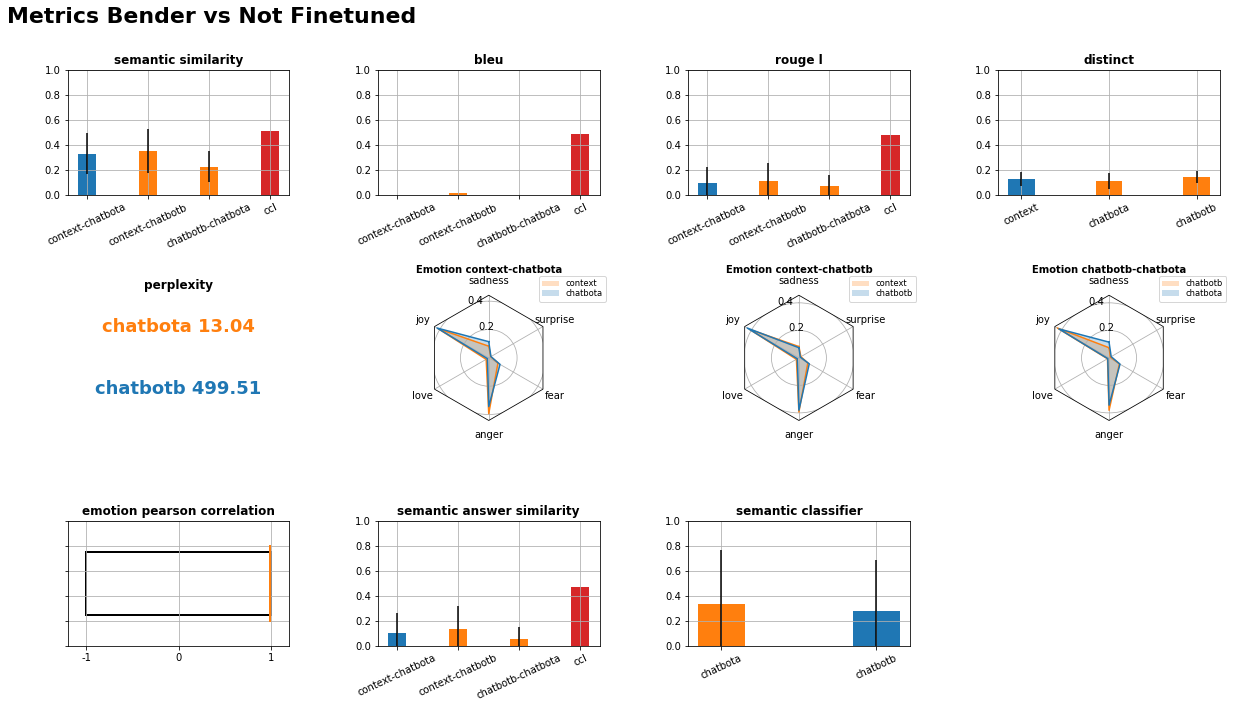

In [10]:
plotMetricsChars(characters)